In [3]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config


In [8]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location


def getCountry(t):
    loc = getLocation(t)
    if(loc):
        return loc[1].country
    return None

In [9]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
retweet_dir = main_dir + 'data_retweets/'
locations_dir = retweet_dir + 'locations/'

text_list = []
retweet_files = (file for file in os.listdir(retweet_dir) if os.path.isfile(os.path.join(retweet_dir, file)))

for file in sorted(retweet_files):
    print('Reading... ' + file)
    df = pd.read_csv(retweet_dir + file)
    print(str(len(df)) + ' Tweets!')
#     print("Extracting locations .. .  .")
    
#     df['country'] = df.apply(getCountry, axis = 1)
    df_text = df[['created_at', 'full_text', 'entities', 'user', 'place', 'coordinates']]
    
    text_list.append(df_text)
    print(file + ' processing done!')
    print()



Reading... 05-20-2020.csv
618997 Tweets!
05-20-2020.csv processing done!

Reading... 05-21-2020.csv
578771 Tweets!
05-21-2020.csv processing done!

Reading... 05-22-2020.csv
551356 Tweets!
05-22-2020.csv processing done!

Reading... 05-23-2020.csv
408986 Tweets!
05-23-2020.csv processing done!

Reading... 05-24-2020.csv
420865 Tweets!
05-24-2020.csv processing done!

Reading... 05-25-2020.csv
468422 Tweets!
05-25-2020.csv processing done!

Reading... 05-26-2020.csv
530600 Tweets!
05-26-2020.csv processing done!

Reading... 05-27-2020.csv
509952 Tweets!
05-27-2020.csv processing done!

Reading... 05-28-2020.csv
554402 Tweets!
05-28-2020.csv processing done!

Reading... 05-29-2020.csv
472344 Tweets!
05-29-2020.csv processing done!

Reading... 05-30-2020.csv
371213 Tweets!
05-30-2020.csv processing done!

Reading... 05-31-2020.csv
330653 Tweets!
05-31-2020.csv processing done!



In [12]:
%%time
print("Merging all the daily data. .  .")
df_text = pd.concat(text_list).drop_duplicates().reset_index(drop = True)
print("Concatenated!")
print("Converting dates to pandas format. .  .")
df_text.created_at = pd.to_datetime(df_text.created_at)
df_text['date'] = df_text.created_at.apply(lambda x: x.strftime("%Y-%m-%d"))
print("[date] column added")
print("Extracting Locations. .  .")
df_text = df_text[(df_text.date >= '2020-05-20') & (df_text.date <= '2020-05-31')]
df_text['country'] = df_text.apply(getCountry, axis = 1)
print("Done!, dropping extra features. .  .")
df_text.drop(['user', 'place', 'coordinates'], axis = 1, inplace = True)

df_text.head()

Merging all the daily data. .  .
Concatenated!
Converting dates to pandas format. .  .
[date] column added
Extracting Locations. .  .
Done!, dropping extra features. .  .
CPU times: user 1h 18min 20s, sys: 1min 52s, total: 1h 20min 13s
Wall time: 1h 20min 11s


created_at  \
0 2020-05-21 00:00:01+00:00   
1 2020-05-21 00:00:01+00:00   
2 2020-05-21 00:00:00+00:00   
3 2020-05-21 00:00:00+00:00   
4 2020-05-21 00:00:00+00:00   

                                           full_text  \
0  RT @latoyajackson: I’m ready for this!\n#Wedne...   
1  We know this is a tough financial time for man...   
2  How the COVID “Experts” Got Everything Wrong! ...   
3  We are LIVE for our #TLCtransform chat on Pivo...   
4  RT @FLOTUS: Productive call today with our Sta...   

                                            entities        date  \
0  {'hashtags': [{'text': 'WednesdayThoughts', 'i...  2020-05-21   
1  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-21   
2  {'hashtags': [{'text': 'Covid_19', 'indices': ...  2020-05-21   
3  {'hashtags': [{'text': 'TLCtransform', 'indice...  2020-05-21   
4  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-21   

         country  
0           None  
1           None  
2  United States  
3  United States  
4           None

### Merging new data

In [59]:
file = '06-01-2020.csv'

print("Reading the data. .  .")
df_new = pd.read_csv(retweet_dir + file)
df_new = df_new[['created_at', 'full_text', 'entities', 'user', 'place', 'coordinates']]

print("Converting dates to pandas format. .  .")
df_new.created_at = pd.to_datetime(df_new.created_at)
df_new['date'] = df_new.created_at.apply(lambda x: x.strftime("%Y-%m-%d"))
print("[date] column added")

print("Extracting Locations. .  .")
df_new = df_new[df_new.date <= '2020-06-01']
df_new['country'] = df_new.apply(getCountry, axis = 1)

print("Done!, dropping extra features. .  .")
df_new.drop(['user', 'place', 'coordinates'], axis = 1, inplace = True)


print("Calculating the polarity scores. .  .")
df_new['vader_score'] = df_new.apply(lambda x: sid.polarity_scores(cleanForVader(x))['compound'], axis = 1)

print("Classifying the sentiments based on the polarity scores. .  .")
df_new['sentiment'] = df_new.vader_score.apply(lambda x: 'positive' if x > 0.4 else ('negative' if x < -0.4 else 'neutral'))

print("Replace countries with codes. .  .")
codes_df = pd.read_csv('country_codes.csv')
df_new = pd.merge(df_new, codes_df, on = 'country', how = 'left')
df_new.drop(['country'], axis = 1, inplace = True)

print("Extracting hashtags. .  .")
df_new['hashtags'] = df_new.entities.apply(getHashtags)

df_new.head()

Reading the data. .  .
Converting dates to pandas format. .  .
[date] column added
Extracting Locations. .  .
Done!, dropping extra features. .  .
Calculating the polarity scores. .  .
Classifying the sentiments based on the polarity scores. .  .
Replace countries with codes. .  .
Extracting hashtags. .  .


created_at  \
0 2020-06-01 23:59:59+00:00   
1 2020-06-01 23:59:59+00:00   
2 2020-06-01 23:59:59+00:00   
3 2020-06-01 23:59:59+00:00   
4 2020-06-01 23:59:59+00:00   

                                           full_text  \
0  RT @EricTopol: What prevents #COVID19 spread? ...   
1  RT @trvrb: As #COVID19 spread, we continually ...   
2  RT @pinkk9lover: 🙏🏻 @realDonaldTrump Governors...   
3  Today's COVID and Markets Missive and SPECIAL ...   
4  RT @CPRAction: 😡@NYCMayor &amp; @NYGovCuomo ha...   

                                            entities        date  vader_score  \
0  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-06-01       0.1680   
1  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-06-01       0.2960   
2  {'hashtags': [], 'symbols': [], 'user_mentions...  2020-06-01       0.0000   
3  {'hashtags': [{'text': 'investing', 'indices':...  2020-06-01       0.5319   
4  {'hashtags': [{'text': 'stayhome', 'indices': ...  2020-06-01      -0.4019   

  sentiment code                     hashtags  
0   neutral  NaN                           []  
1   neutral  NaN                           []  
2   neutral  USA                           []  
3  positive  USA                  [investing]  
4  negative  NaN  [stayhome, FlattenTheCurve]

In [72]:
print("Merging all the daily data. .  .")
df_text.append(df_new).drop_duplicates()
print("Concatenated!")

df_text.tail()

Merging all the daily data. .  .


TypeError: unhashable type: 'list'

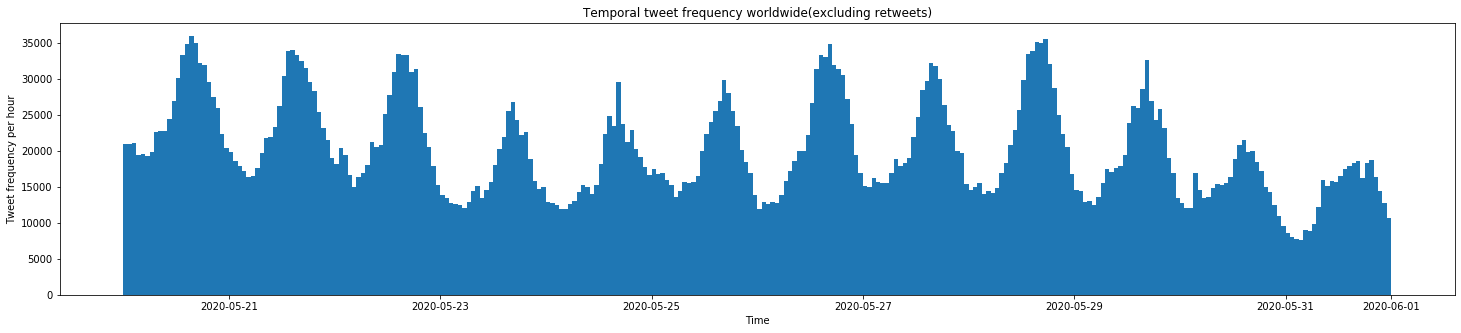

In [73]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide(excluding retweets)', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(df_text.created_at.values, bins = 24*len(text_list))
plt.show()

In [14]:
def cleanForVader(tweet):
    text = tweet.full_text
    
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
        
    text = re.sub('RT|cc', '', text)  # remove RT and cc
    text = re.sub('#', '', text)  # remove hashtag symbol
    text = re.sub('@\S+', '', text) # remove @mentions
    text = re.sub('\S+&\S+', '', text) # remove &amps and other symbols
    text = re.sub('&\S+', '', text) # remove &amps and other symbols
    text = re.sub(r'‚Ä¶', '', text)
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

def cleanText(tweet, stem = False):
    text = cleanForVader(tweet)
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+',' ', text) # remove non ASCII characters
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # remove punctuations
    
    t_list = []
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19', 'covid__19'])
    t_list = text.split()
    t_list = [word for word in t_list if word not in stop_words]
    
    if stem:
        stemmer = SnowballStemmer('english')
        t_list = [stemmer.stem(t) for t in t_list]

    return ' '.join(t_list)

In [15]:
sid = SentimentIntensityAnalyzer()
print("Calculating the polarity scores. .  .")
df_text['vader_score'] = df_text.apply(lambda x: sid.polarity_scores(cleanForVader(x))['compound'], axis = 1)
print("Classifying the sentiments based on the polarity scores. .  .")
df_text['sentiment'] = df_text.vader_score.apply(lambda x: 'positive' if x > 0.4 else ('negative' if x < -0.4 else 'neutral'))
df_text.head()

Calculating the polarity scores. .  .
Classifying the sentiments based on the polarity scores. .  .


created_at  \
0 2020-05-21 00:00:01+00:00   
1 2020-05-21 00:00:01+00:00   
2 2020-05-21 00:00:00+00:00   
3 2020-05-21 00:00:00+00:00   
4 2020-05-21 00:00:00+00:00   

                                           full_text  \
0  RT @latoyajackson: I’m ready for this!\n#Wedne...   
1  We know this is a tough financial time for man...   
2  How the COVID “Experts” Got Everything Wrong! ...   
3  We are LIVE for our #TLCtransform chat on Pivo...   
4  RT @FLOTUS: Productive call today with our Sta...   

                                            entities        date  \
0  {'hashtags': [{'text': 'WednesdayThoughts', 'i...  2020-05-21   
1  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-21   
2  {'hashtags': [{'text': 'Covid_19', 'indices': ...  2020-05-21   
3  {'hashtags': [{'text': 'TLCtransform', 'indice...  2020-05-21   
4  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-21   

         country  vader_score sentiment  
0           None       0.4199  positive  
1           None      -0.1779   neutral  
2  United States      -0.1342   neutral  
3  United States       0.4588  positive  
4           None       0.0772   neutral

In [16]:
codes_df = pd.read_csv('country_codes.csv')
df_text = pd.merge(df_text, codes_df, on = 'country', how = 'left')
df_text.drop(['country'], axis = 1, inplace = True)
df_text.tail()

created_at  \
5816183 2020-05-30 23:59:42+00:00   
5816184 2020-05-30 23:59:41+00:00   
5816185 2020-05-30 23:59:41+00:00   
5816186 2020-05-30 23:59:40+00:00   
5816187 2020-05-30 23:59:40+00:00   

                                                 full_text  \
5816183  NEGLIGENCE of #Trump on #coronavirus #COVID19 ...   
5816184  RT @GHS: We cannot begin to address health dis...   
5816185  RT @K_G_Andersen: My exact quote when Helen as...   
5816186  Why, would anyone want to protest directly out...   
5816187  RT @brianvastag: Researchers warn some #covid1...   

                                                  entities        date  \
5816183  {'hashtags': [{'text': 'Trump', 'indices': [14...  2020-05-30   
5816184  {'hashtags': [], 'symbols': [], 'user_mentions...  2020-05-30   
5816185  {'hashtags': [], 'symbols': [], 'user_mentions...  2020-05-30   
5816186  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-30   
5816187  {'hashtags': [{'text': 'covid19', 'indices': [...  2020-05-30   

         vader_score sentiment code  
5816183       0.0000   neutral  NaN  
5816184      -0.6249  negative  NaN  
5816185       0.0000   neutral  NaN  
5816186      -0.5386  negative  GBR  
5816187      -0.4767  negative  NaN

In [17]:
df_text.code.value_counts()[:10]

USA    1134265
IND     403067
GBR     396484
CAN     170493
NGA      67981
ZAF      51479
AUS      51371
PAK      43760
IRL      37508
KEN      29449
Name: code, dtype: int64

In [18]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic", "covid__19"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

In [19]:
df_text['hashtags'] = df_text.entities.apply(getHashtags)
df_text.tail()

created_at  \
5816183 2020-05-30 23:59:42+00:00   
5816184 2020-05-30 23:59:41+00:00   
5816185 2020-05-30 23:59:41+00:00   
5816186 2020-05-30 23:59:40+00:00   
5816187 2020-05-30 23:59:40+00:00   

                                                 full_text  \
5816183  NEGLIGENCE of #Trump on #coronavirus #COVID19 ...   
5816184  RT @GHS: We cannot begin to address health dis...   
5816185  RT @K_G_Andersen: My exact quote when Helen as...   
5816186  Why, would anyone want to protest directly out...   
5816187  RT @brianvastag: Researchers warn some #covid1...   

                                                  entities        date  \
5816183  {'hashtags': [{'text': 'Trump', 'indices': [14...  2020-05-30   
5816184  {'hashtags': [], 'symbols': [], 'user_mentions...  2020-05-30   
5816185  {'hashtags': [], 'symbols': [], 'user_mentions...  2020-05-30   
5816186  {'hashtags': [{'text': 'COVID19', 'indices': [...  2020-05-30   
5816187  {'hashtags': [{'text': 'covid19', 'indices': [...  2020-05-30   

         vader_score sentiment code                                  hashtags  
5816183       0.0000   neutral  NaN                                   [Trump]  
5816184      -0.6249  negative  NaN                                        []  
5816185       0.0000   neutral  NaN                                        []  
5816186      -0.5386  negative  GBR  [riots2020, protests, GeorgeFloydMurder]  
5816187      -0.4767  negative  NaN                                        []

In [20]:
def getTermFrequency(tweets, count):
    tweet_series = tweets.apply(cleanText, axis = 1)
    tweet_list = [word for tweet in tweet_series for word in tweet.split()]
    counts = Counter(tweet_list).most_common(count)
    counts_df = pd.DataFrame(counts)
    counts_df.columns = ['word', 'frequency']
    return counts_df

In [21]:
def getMovingAverages(df, frac, roll):
    ot = df.sample(frac = frac)
    ot['created_at'] = pd.to_datetime(ot['created_at'])
    ot.index = pd.to_datetime(ot['created_at'])
    ot.sort_index(inplace=True)
    ot['expanding'] = ot['vader_score'].expanding().mean()
    ot['rolling'] = ot['vader_score'].rolling(roll).mean()
    return ot

In [22]:
def getPolarClouds(df, max_words):
    
    positive = df[df['sentiment'] == 'positive'].apply(cleanText, axis = 1)
    negative = df[df['sentiment'] == 'negative'].apply(cleanText, axis = 1)
    neutral = df[df['sentiment'] == 'neutral'].apply(cleanText, axis = 1)
    full = df.apply(cleanText, axis = 1)
    
    positive_list = [word for line in positive for word in line.split()]
    negative_list = [word for line in negative for word in line.split()]
    neutral_list = [word for line in neutral for word in line.split()]
    full_list = [word for line in full for word in line.split()]
    
    positive_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(positive_list))

    negative_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(negative_list))

    neutral_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(neutral_list))
    
    full_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(full_list))

    return {'positive': positive_cloud, 'neutral': neutral_cloud, 'negative': negative_cloud, 'all': full_cloud}

In [23]:
def flattenSeries(s):
    return [w for l in s for w in l]

In [24]:
def displayWordcloud(top_words, title, max_words):
    n_components = len(top_words)
    fig, axs = plt.subplots(int(np.ceil(n_components/2)), 2, figsize = (15, 5*int(np.ceil(n_components/2))))
    fig.tight_layout(pad = 0)
    word_cloud = WordCloud(
#         background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
#         collocations=False,
#         normalize_plurals=False
    )
    t = 0
    flag = 0
    
    for i in range(int(np.ceil(n_components/2))):
        for j in range(2):
            axs[i, j].imshow(word_cloud.generate(' '.join(top_words[t])))
            axs[i, j].set_title("May " + str(t+20), fontsize = 10)
            axs[i, j].axis("off")
            t += 1
            if t == n_components:
                flag = 1
                break
        if flag == 1:
            break

    plt.show()

In [25]:
def getHashtagCorr(series, top_n = 20):
#     print(type(series))
    flat = pd.Series(flattenSeries(series))
#     print(flat.head())
    counts = flat.value_counts()
    counts.sort_index()
    popular_hashtags = counts.reset_index()
    popular_hashtags.columns = ['hashtag', 'counts']
    popular_hashtags = popular_hashtags[:top_n]
    
    # find popular hashtags - make into python set for efficiency
    popular_hashtags_set = set(popular_hashtags['hashtag'])
    
    popular_hashtags_series = series.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
    # drop rows without popular hashtag
    popular_hashtags_series = popular_hashtags_series[popular_hashtags_series.apply(lambda hashtag_list: hashtag_list !=[])]
    
    hashtag_df = pd.DataFrame()
    hashtag_df['hashtags'] = popular_hashtags_series
    
    for hashtag in popular_hashtags_set:
        # make columns to encode presence of hashtags
        hashtag_df['{}'.format(hashtag)] = hashtag_df.hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))

    hashtag_matrix = hashtag_df.drop('hashtags', axis=1)
    return hashtag_matrix.corr()


In [26]:
def displayCorr(series, min_appearance = 400):
    plt.figure(figsize = (20, 20))
    correlations = getHashtagCorr(series, min_appearance)
    sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
    plt.show()

# displayCorr(df_country['hashtags'], 600)

In [27]:
def displayDailyCorr(df):
    fig = plt.figure(figsize = (15, 10*int(np.ceil(len(df)/2))))
    fig.tight_layout()
    j = np.ceil(len(df)/2)
    
    for t in range(len(df)):
        correlations = df.hashtags[t]
        i=t+1
        plt.subplot(j, 2, i).set_title("May " + str(t+20))
        sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
#     fig.suptitle(title)
    plt.show()
    
# p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
# displayCorr(p)

In [28]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
def getTopics(df, n_topics, vectorizer, max_df, stem = False):
    df['cleaned_text'] = df.apply(cleanText, args = (stem,), axis = 1)
    
    vectorizer_tf = vectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = max_df, 
                                min_df = 20)
    
    # apply transformation
    tf = vectorizer_tf.fit_transform(df['cleaned_text'])
    
    # for TF DTM
    lda_tf = LatentDirichletAllocation(n_components = n_topics, random_state=0)
    lda_tf.fit(tf)
    
    return {'model': lda_tf, 'tf': tf, 'vectorizer': vectorizer_tf}
    

countries = ['USA', 'IND', 'GBR', 'CAN', 'AUS']
for country in countries:
    df_country = df_text[df_text.code == country]
    
    topics_tfidf = getTopics(df_country, 10, TfidfVectorizer, 0.6, stem = True)
    topics_count = getTopics(df_country, 10, CountVectorizer, 0.6, stem = True)
    
    vis_tfidf = pyLDAvis.sklearn.prepare(topics_tfidf['model'], topics_tfidf['tf'], topics_tfidf['vectorizer'])
    vis_count = pyLDAvis.sklearn.prepare(topics_count['model'], topics_count['tf'], topics_count['vectorizer']) 
    pyLDAvis.save_html(vis_tfidf, main_dir + 'topics/' + country + '_tfidf_topics.html')
    pyLDAvis.save_html(vis_count, main_dir + 'topics/' + country + '_count_topics.html')

## Filter by country

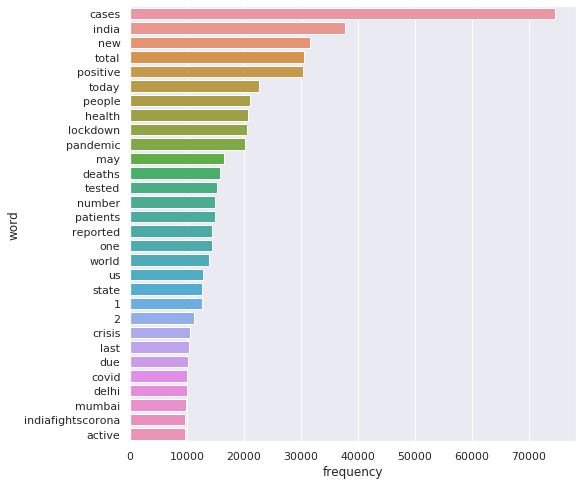

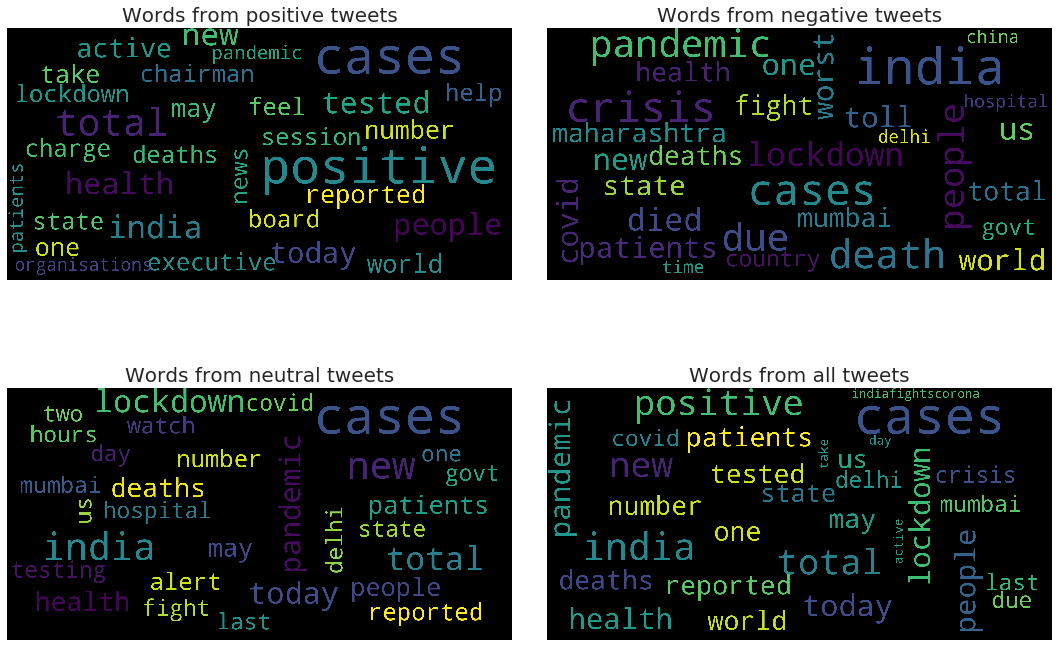

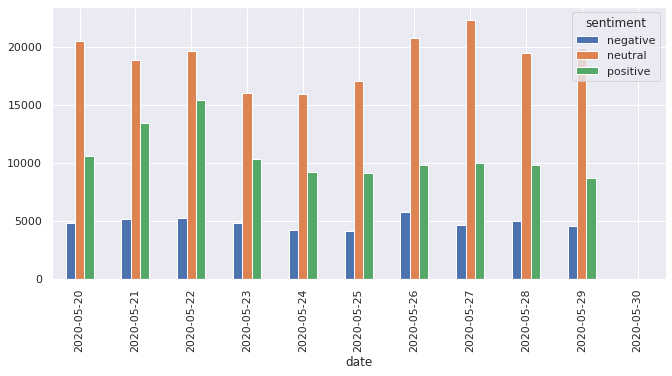

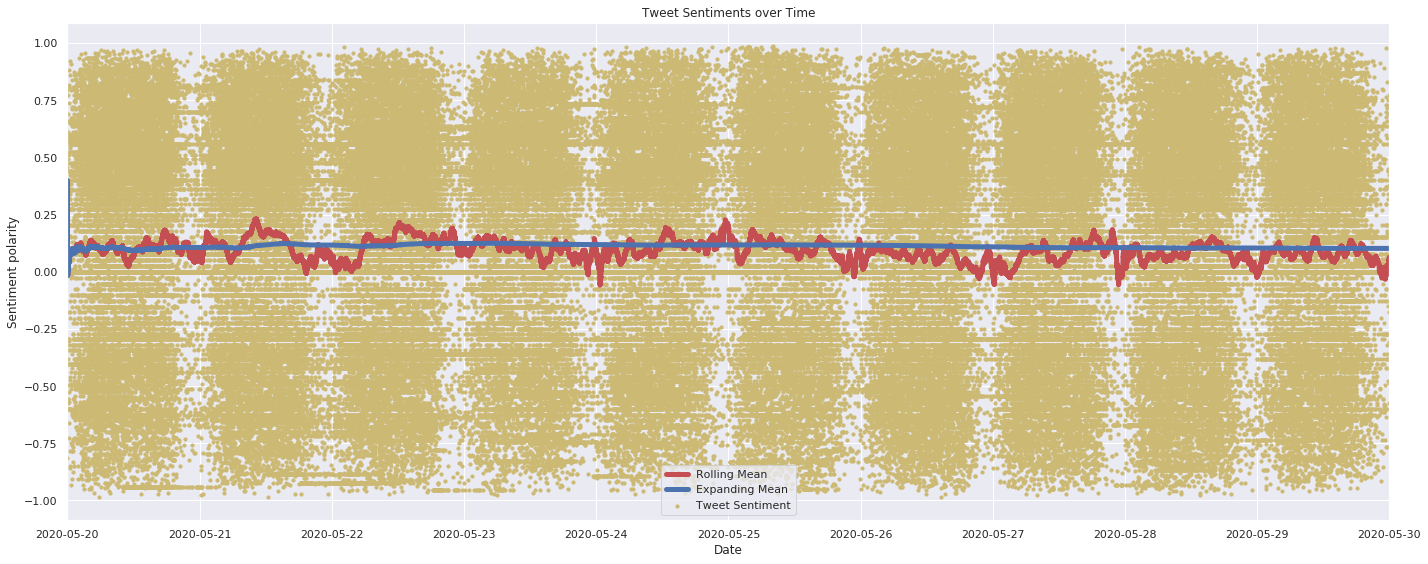

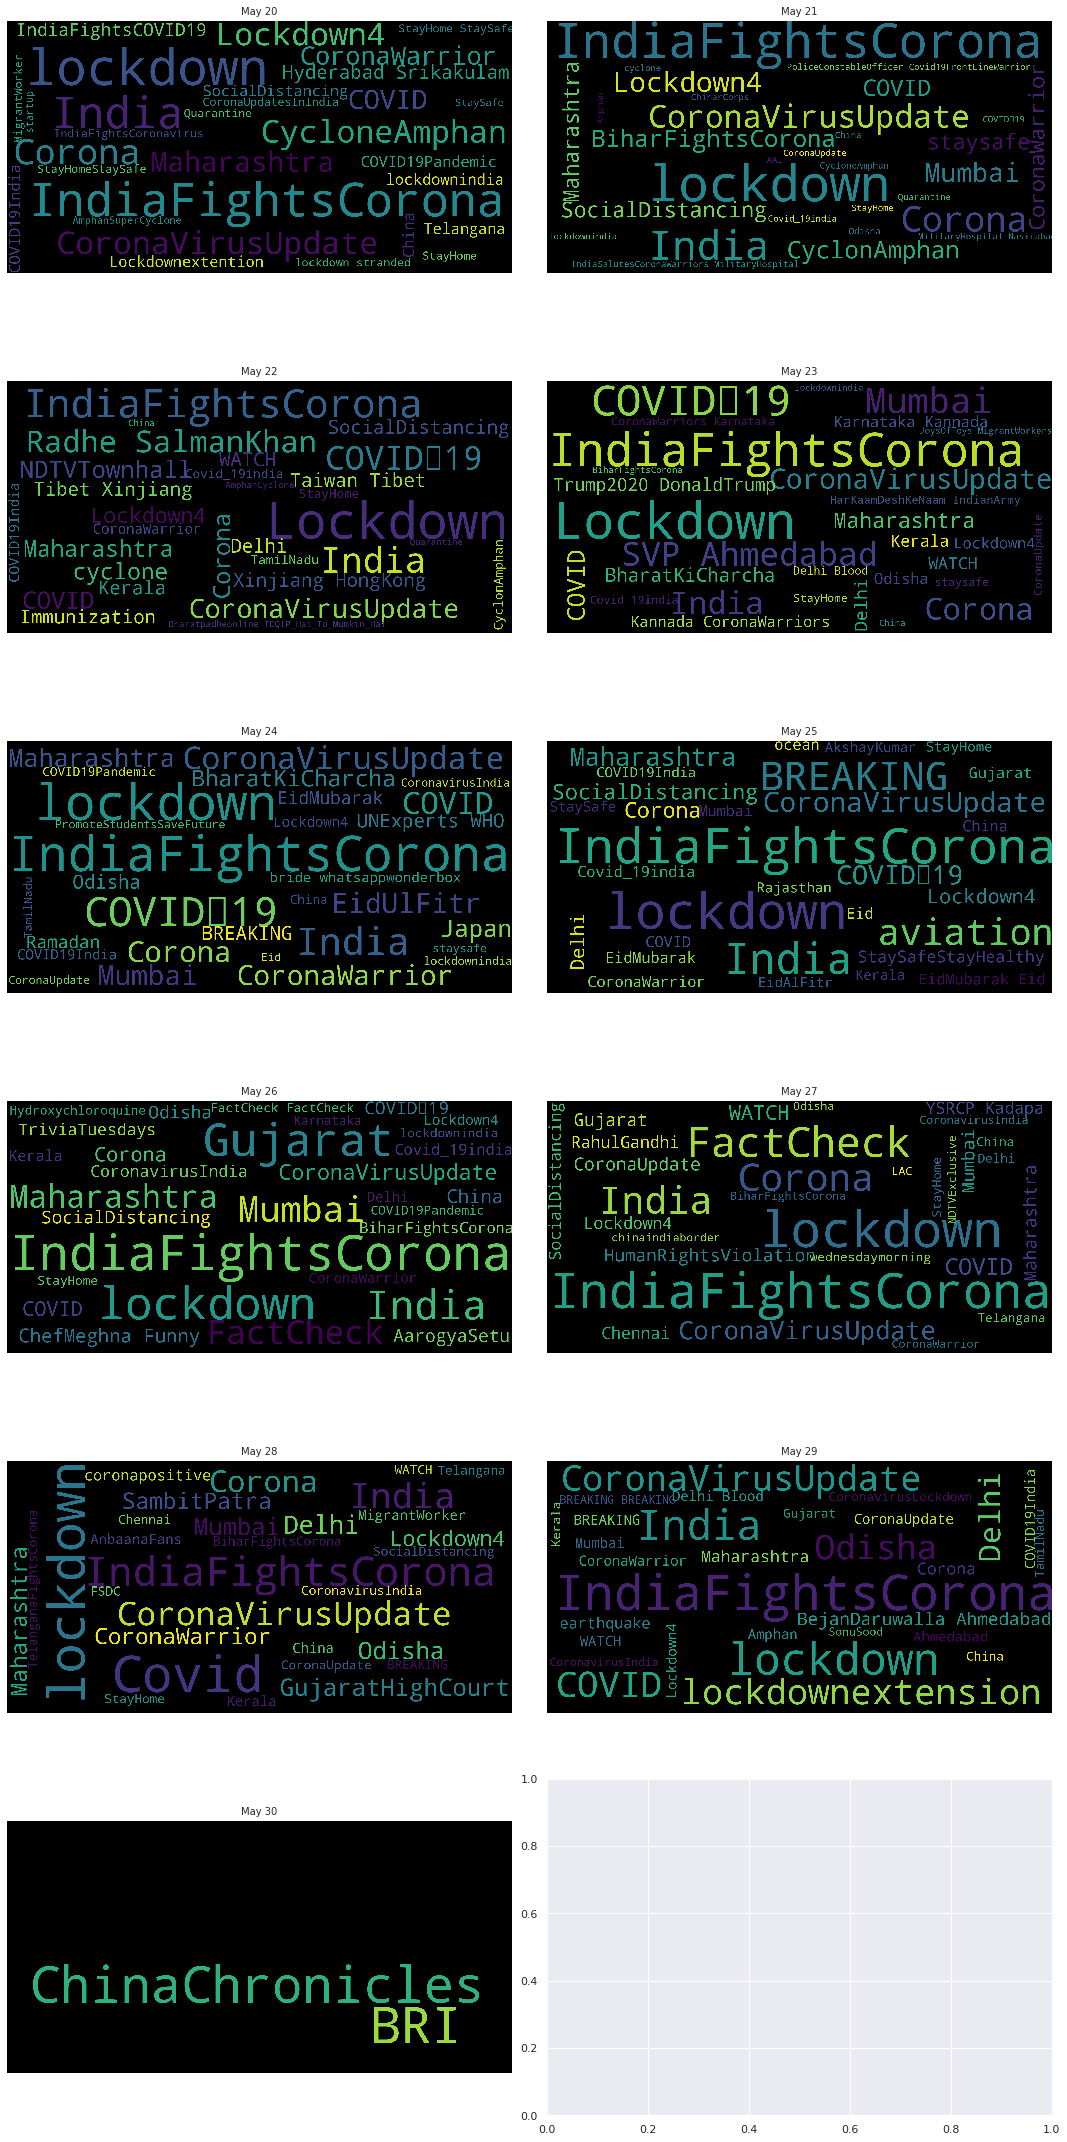

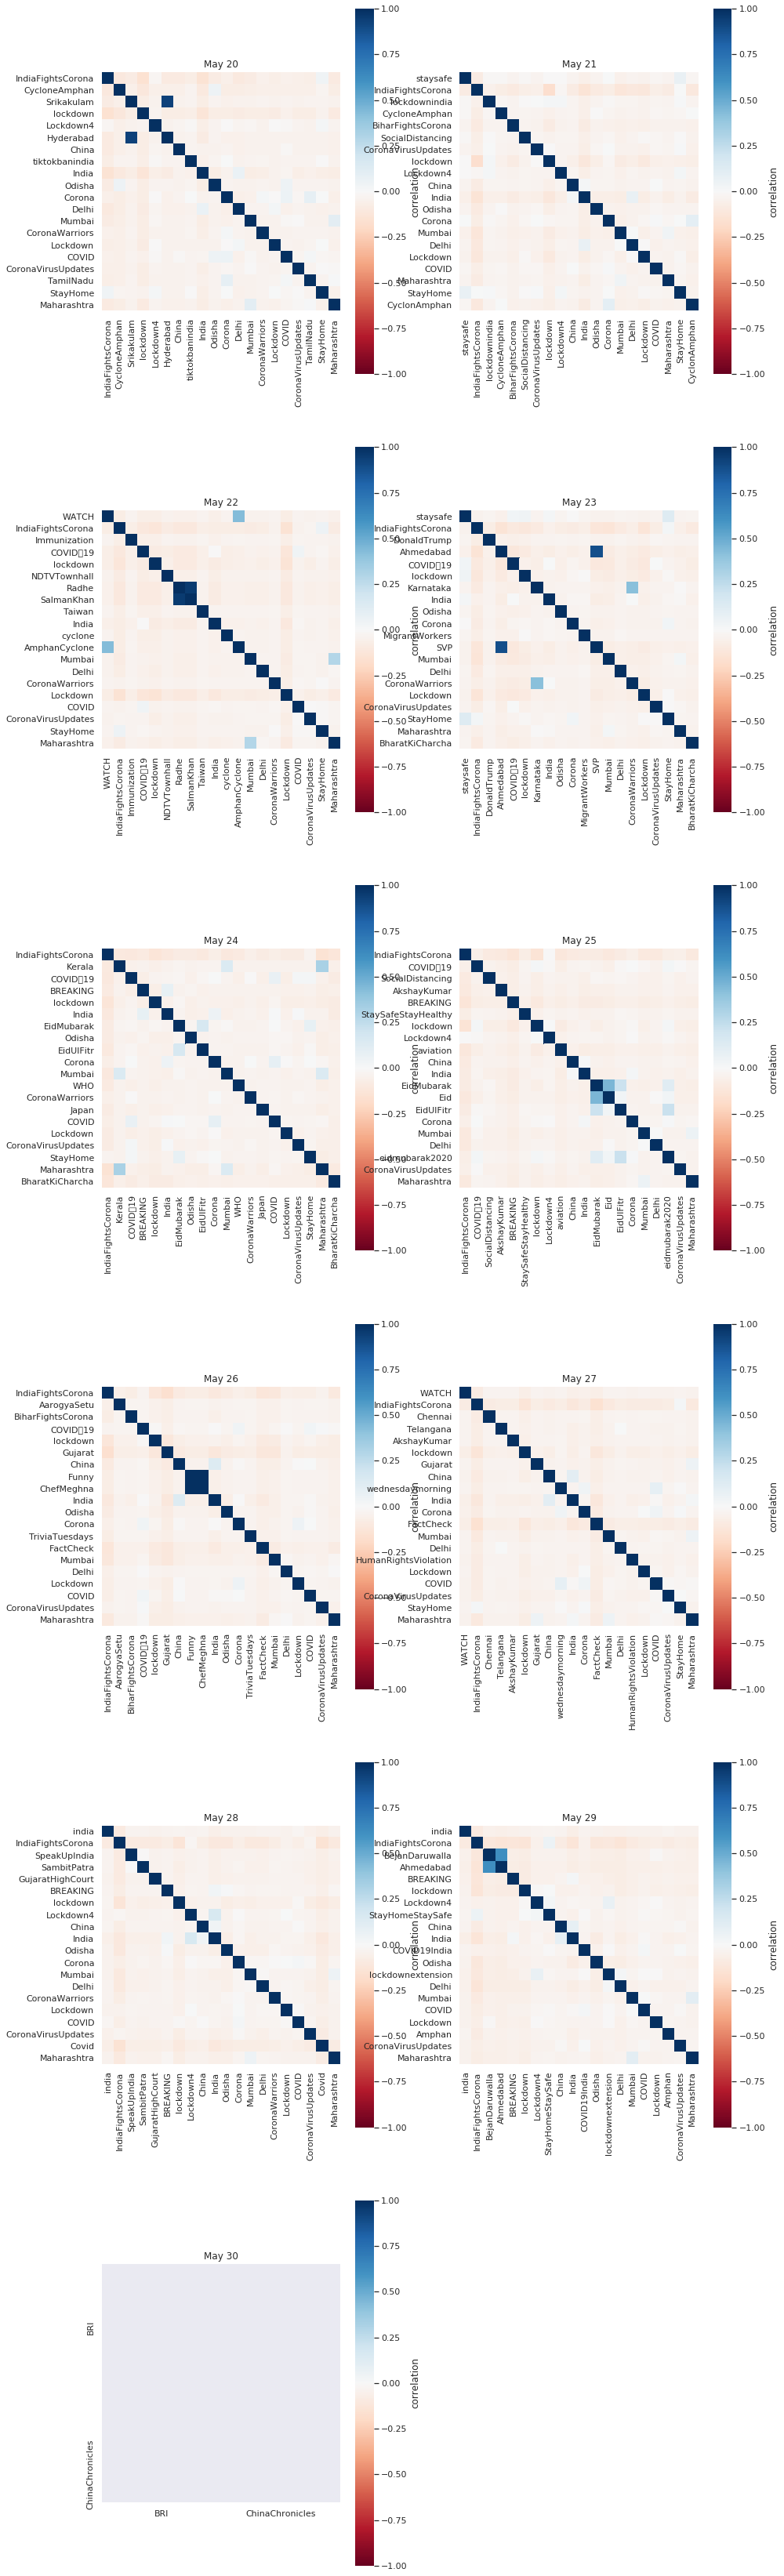

In [123]:
country = 'IND'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# Term Frequency
sns.set(style="darkgrid")
counts_df = getTermFrequency(df_country, tf_count)
counts_df.columns = ['word', 'frequency']
fig, ax = plt.subplots(figsize = (8, 8))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# Hashtags of polar words
clouds = getPolarClouds(df_country, tf_count)

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(clouds.get('positive'))
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(clouds.get('negative'))
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(clouds.get('neutral'))
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(clouds.get('all'))
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
plt.show()



# Sentiment scores daywise
df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# Temporal sentiments
ot = getMovingAverages(df_country, sample, roll)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,30)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.show()



# Clouds of hashtags
p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
displayWordcloud(p.hashtags, "Hashtags cloud", 30)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

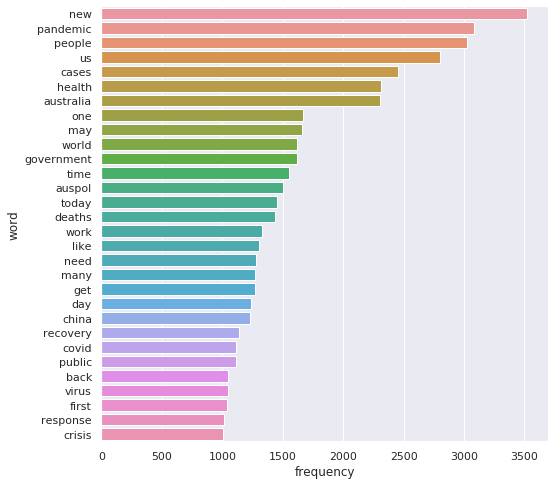

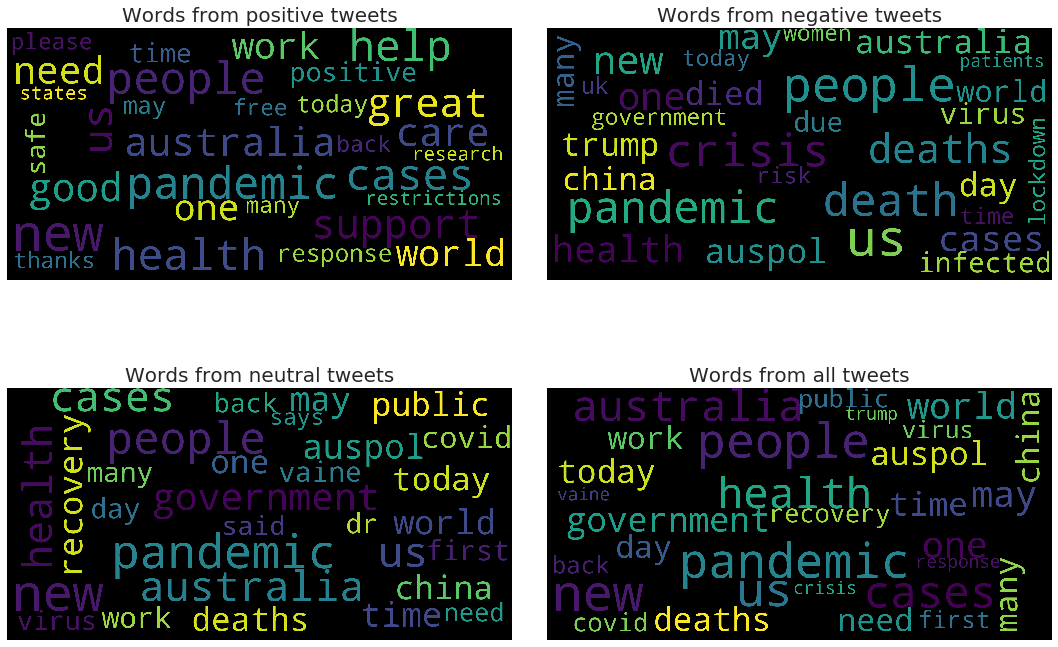

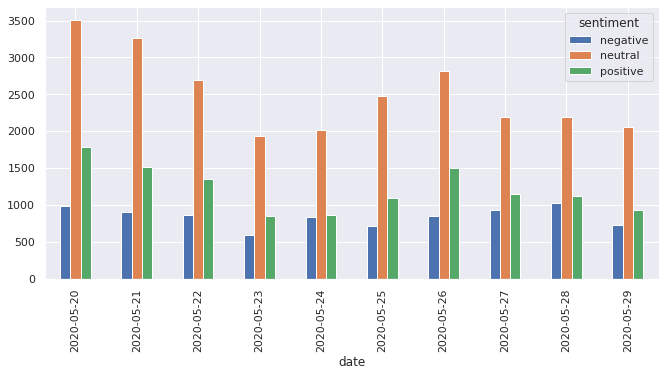

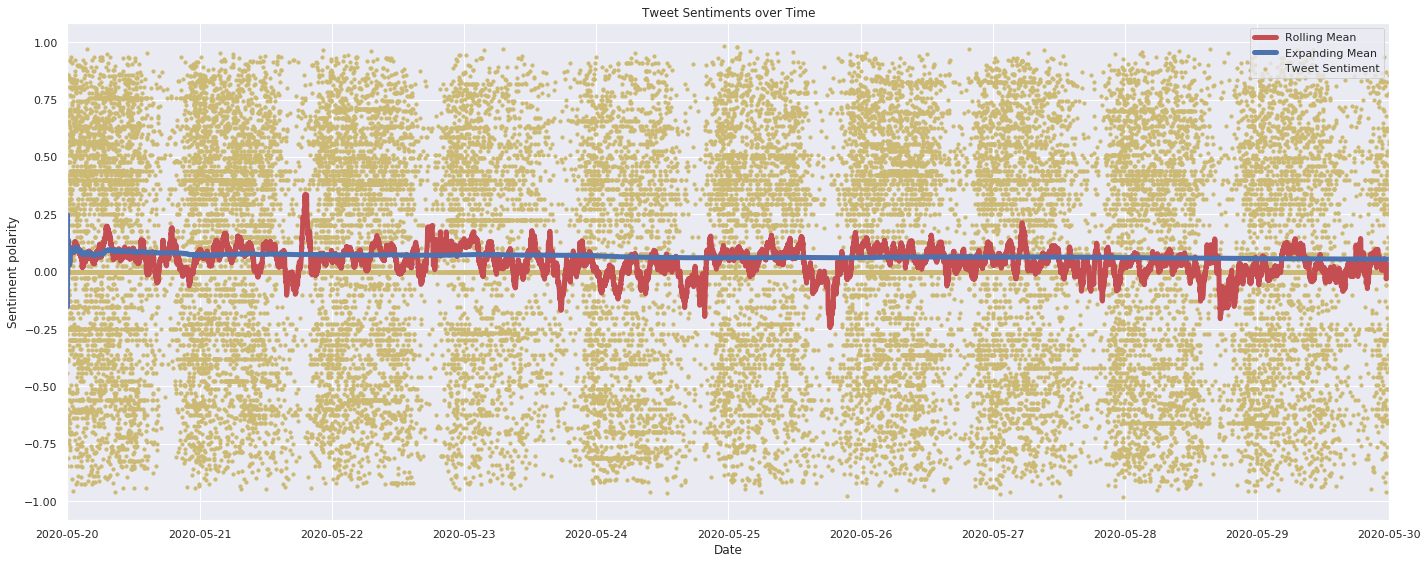

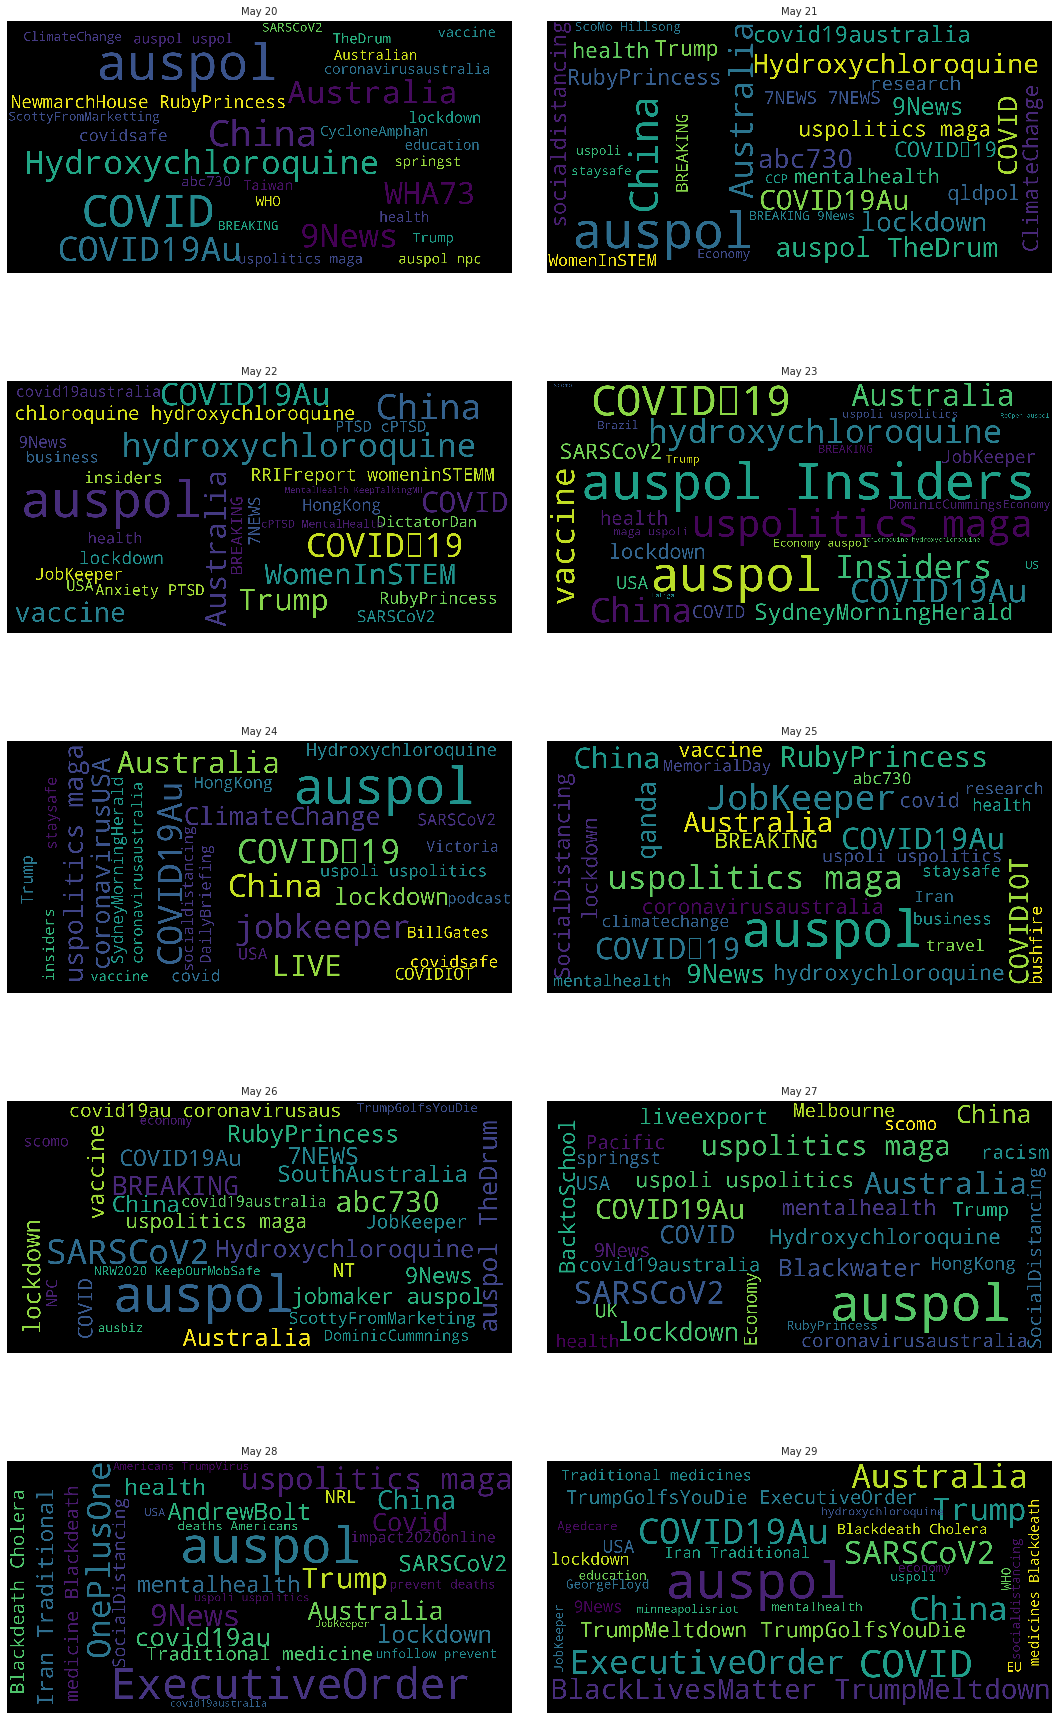

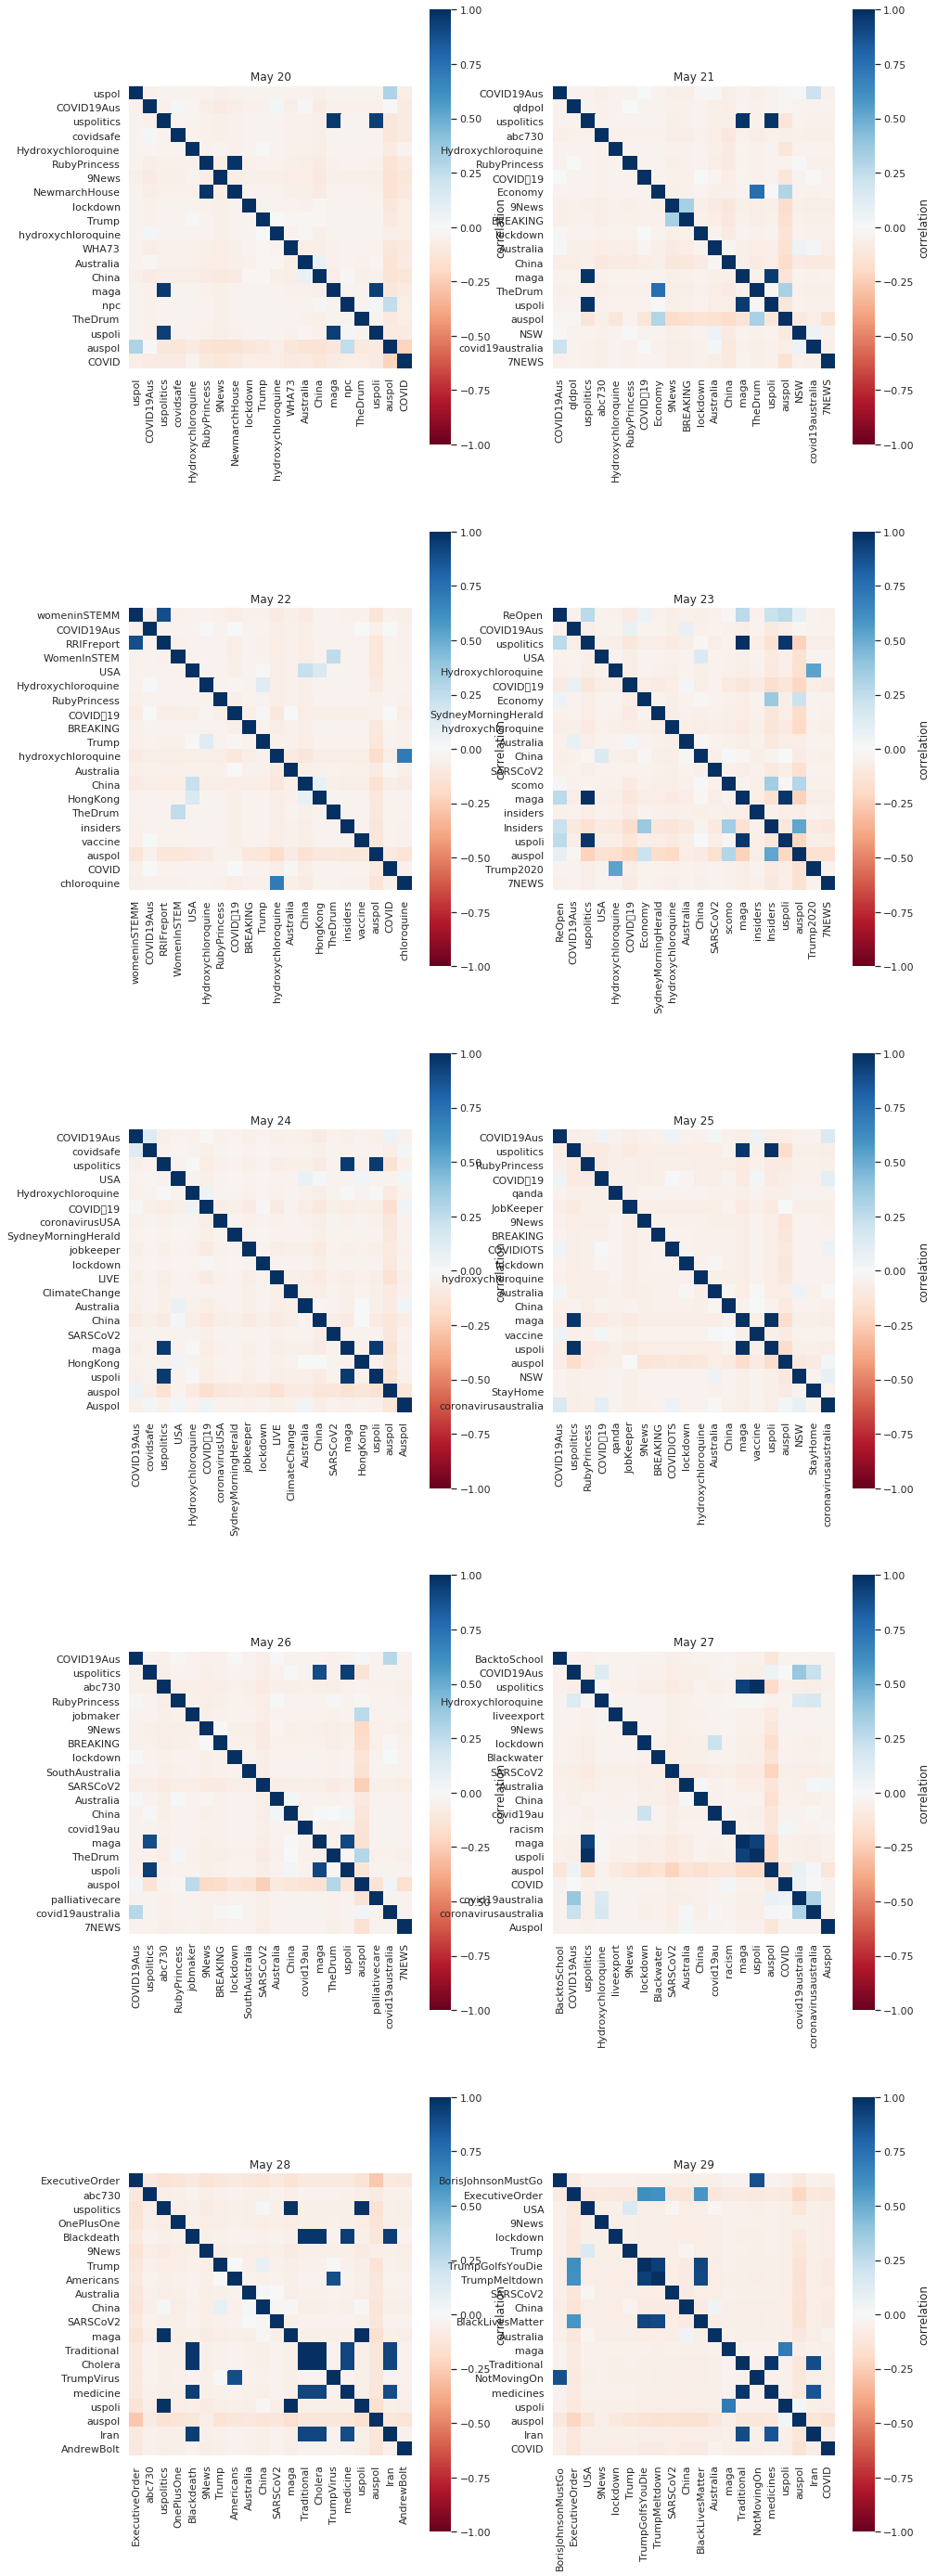

In [122]:
country = 'AUS'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# Term Frequency
sns.set(style="darkgrid")
counts_df = getTermFrequency(df_country, tf_count)
counts_df.columns = ['word', 'frequency']
fig, ax = plt.subplots(figsize = (8, 8))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# Hashtags of polar words
clouds = getPolarClouds(df_country, tf_count)

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(clouds.get('positive'))
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(clouds.get('negative'))
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(clouds.get('neutral'))
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(clouds.get('all'))
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
plt.show()



# Sentiment scores daywise
df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# Temporal sentiments
ot = getMovingAverages(df_country, sample, roll)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,30)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.show()



# Clouds of hashtags
p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
displayWordcloud(p.hashtags, "Hashtags cloud", 30)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

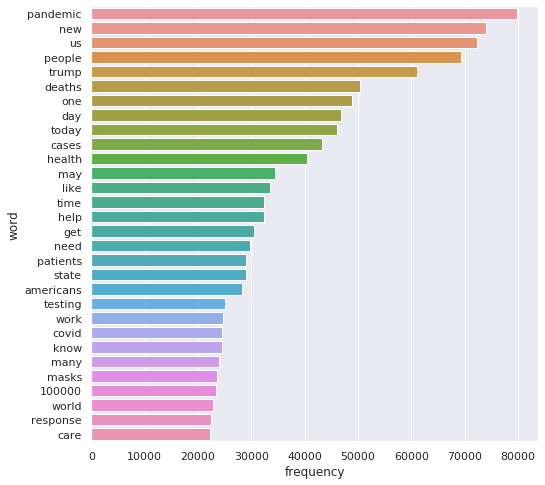

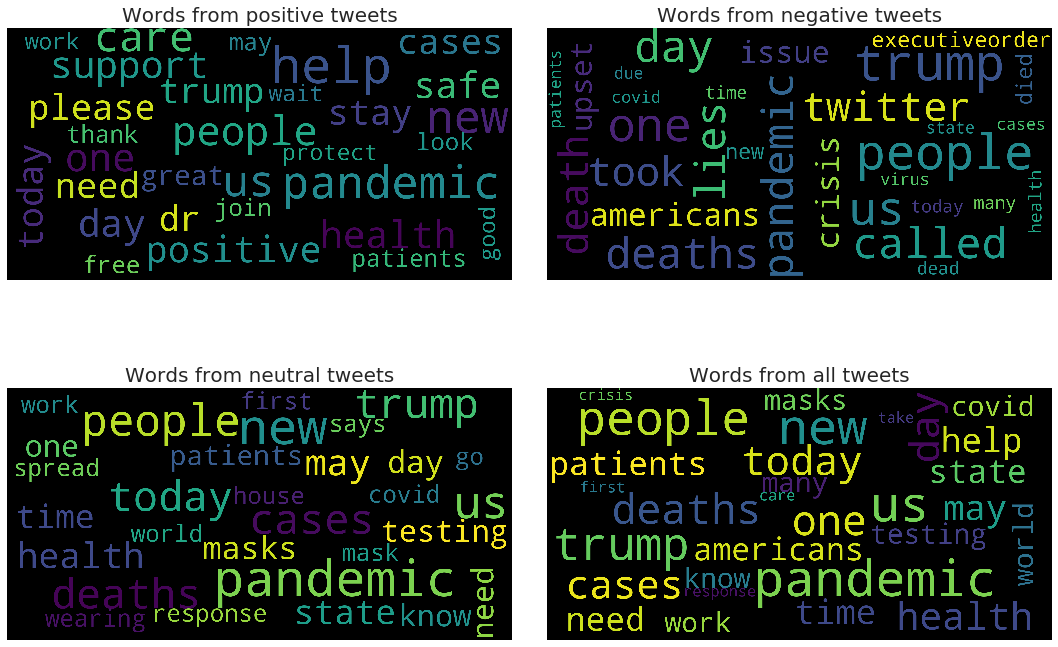

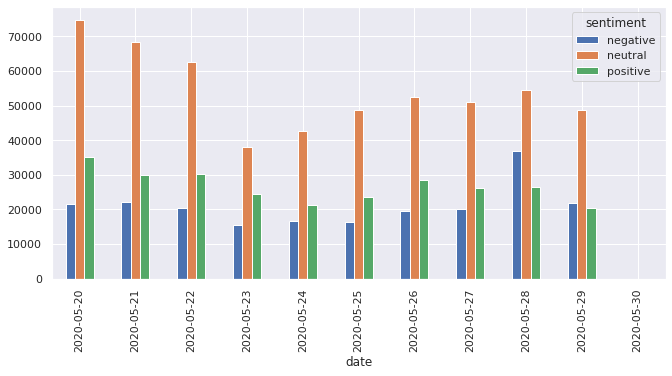

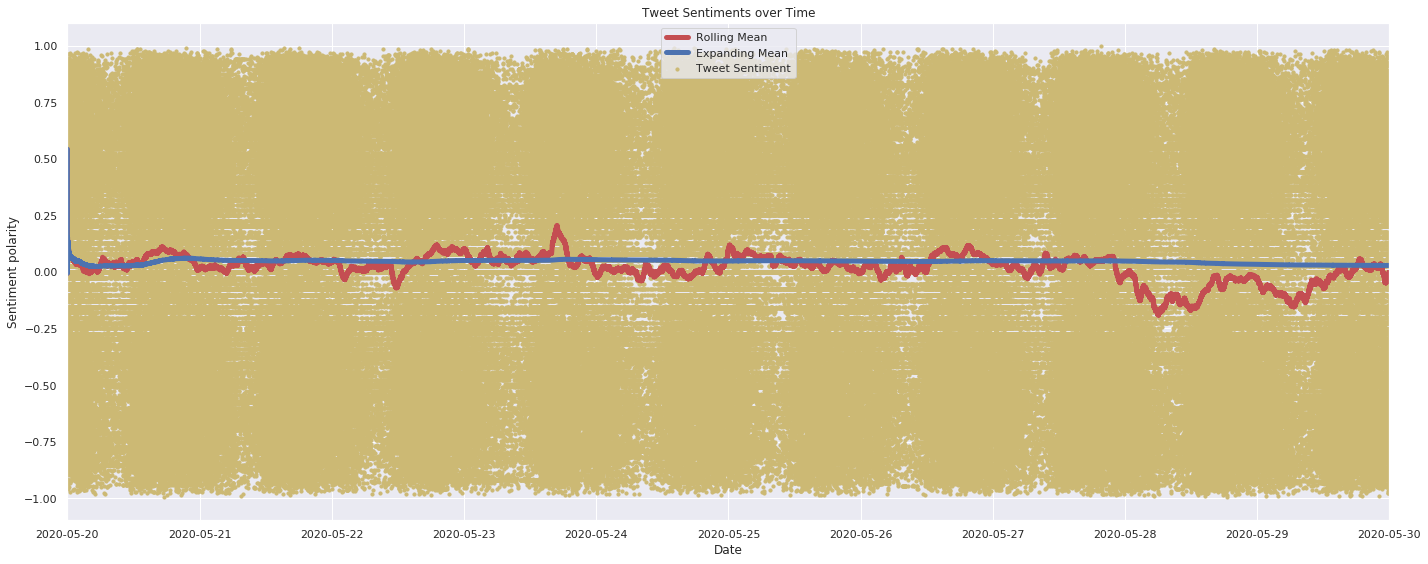

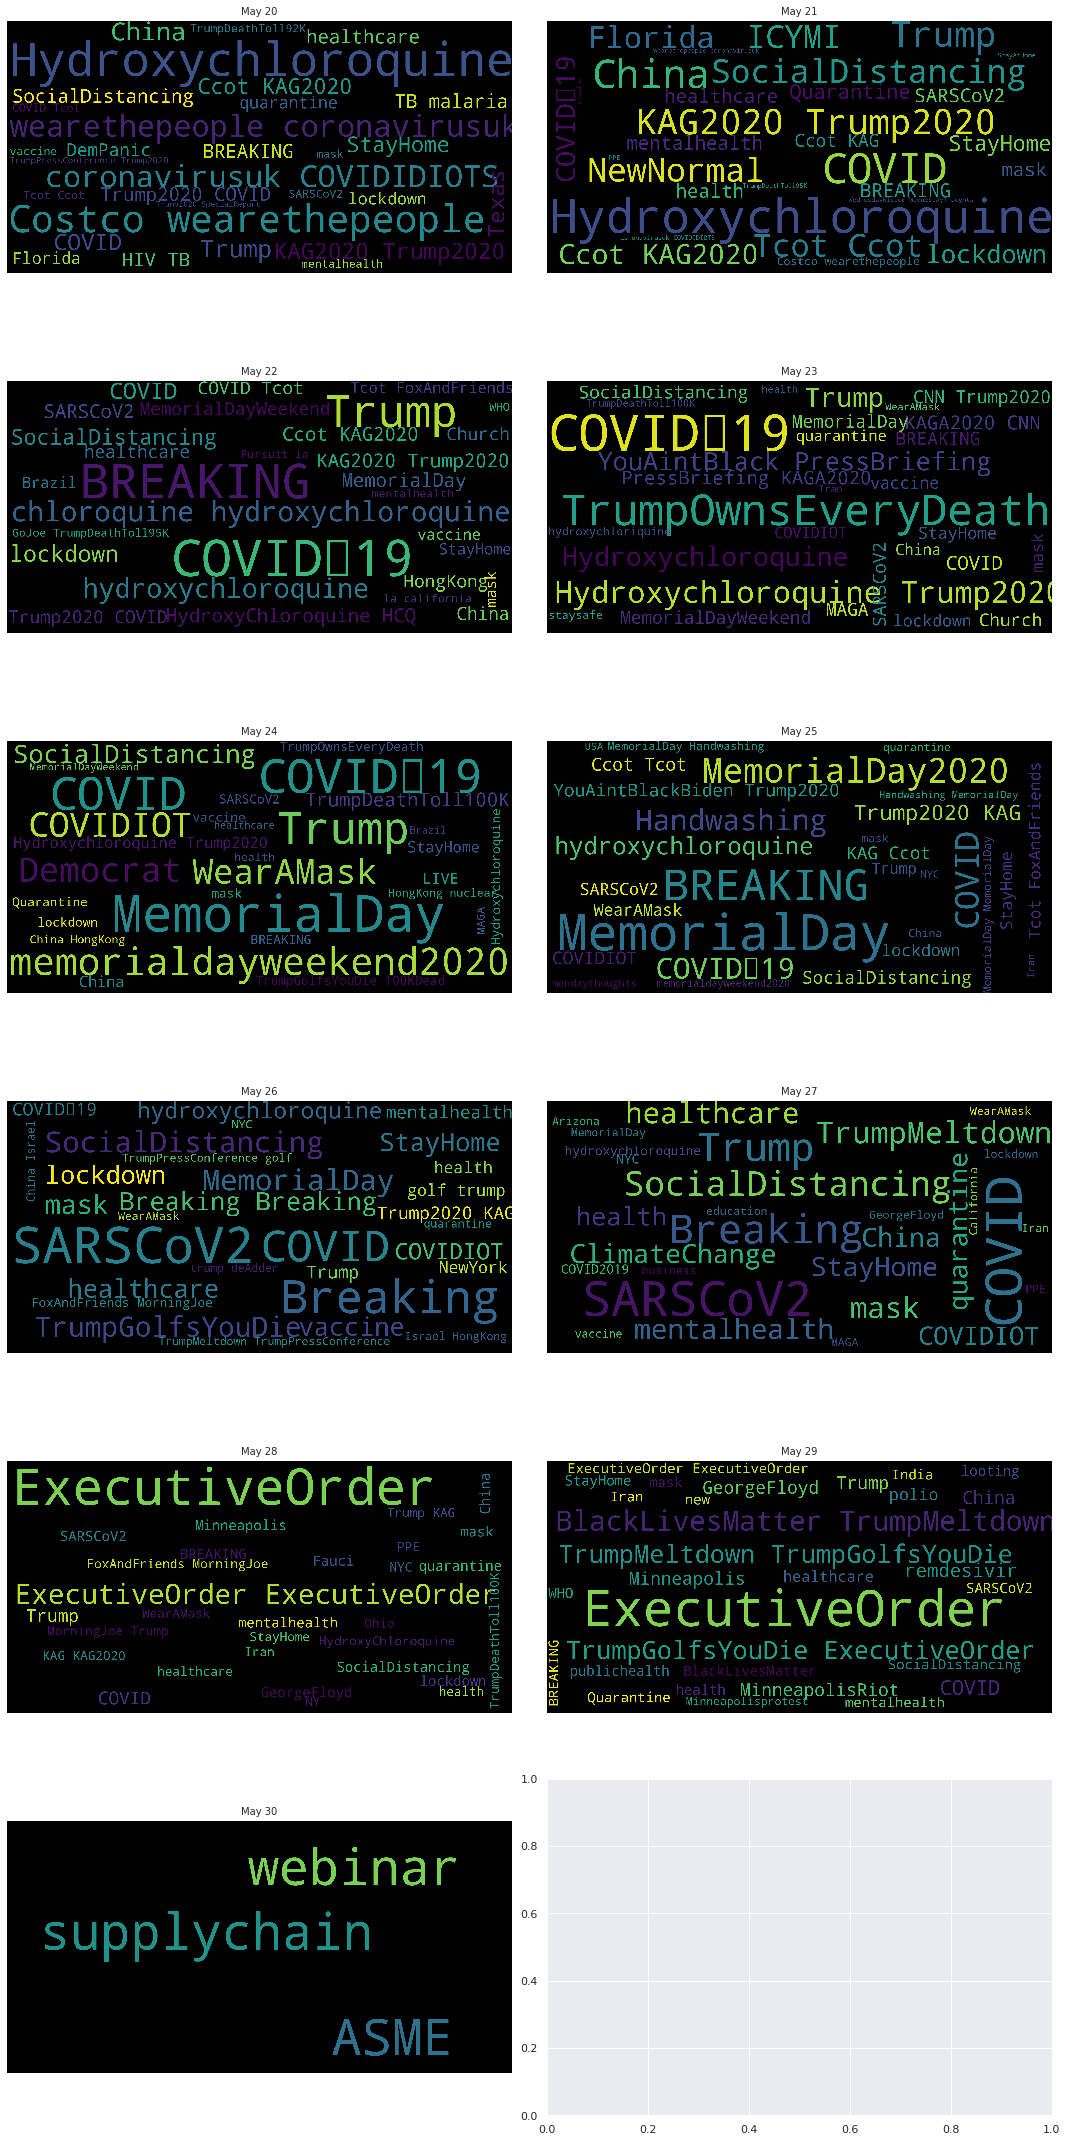

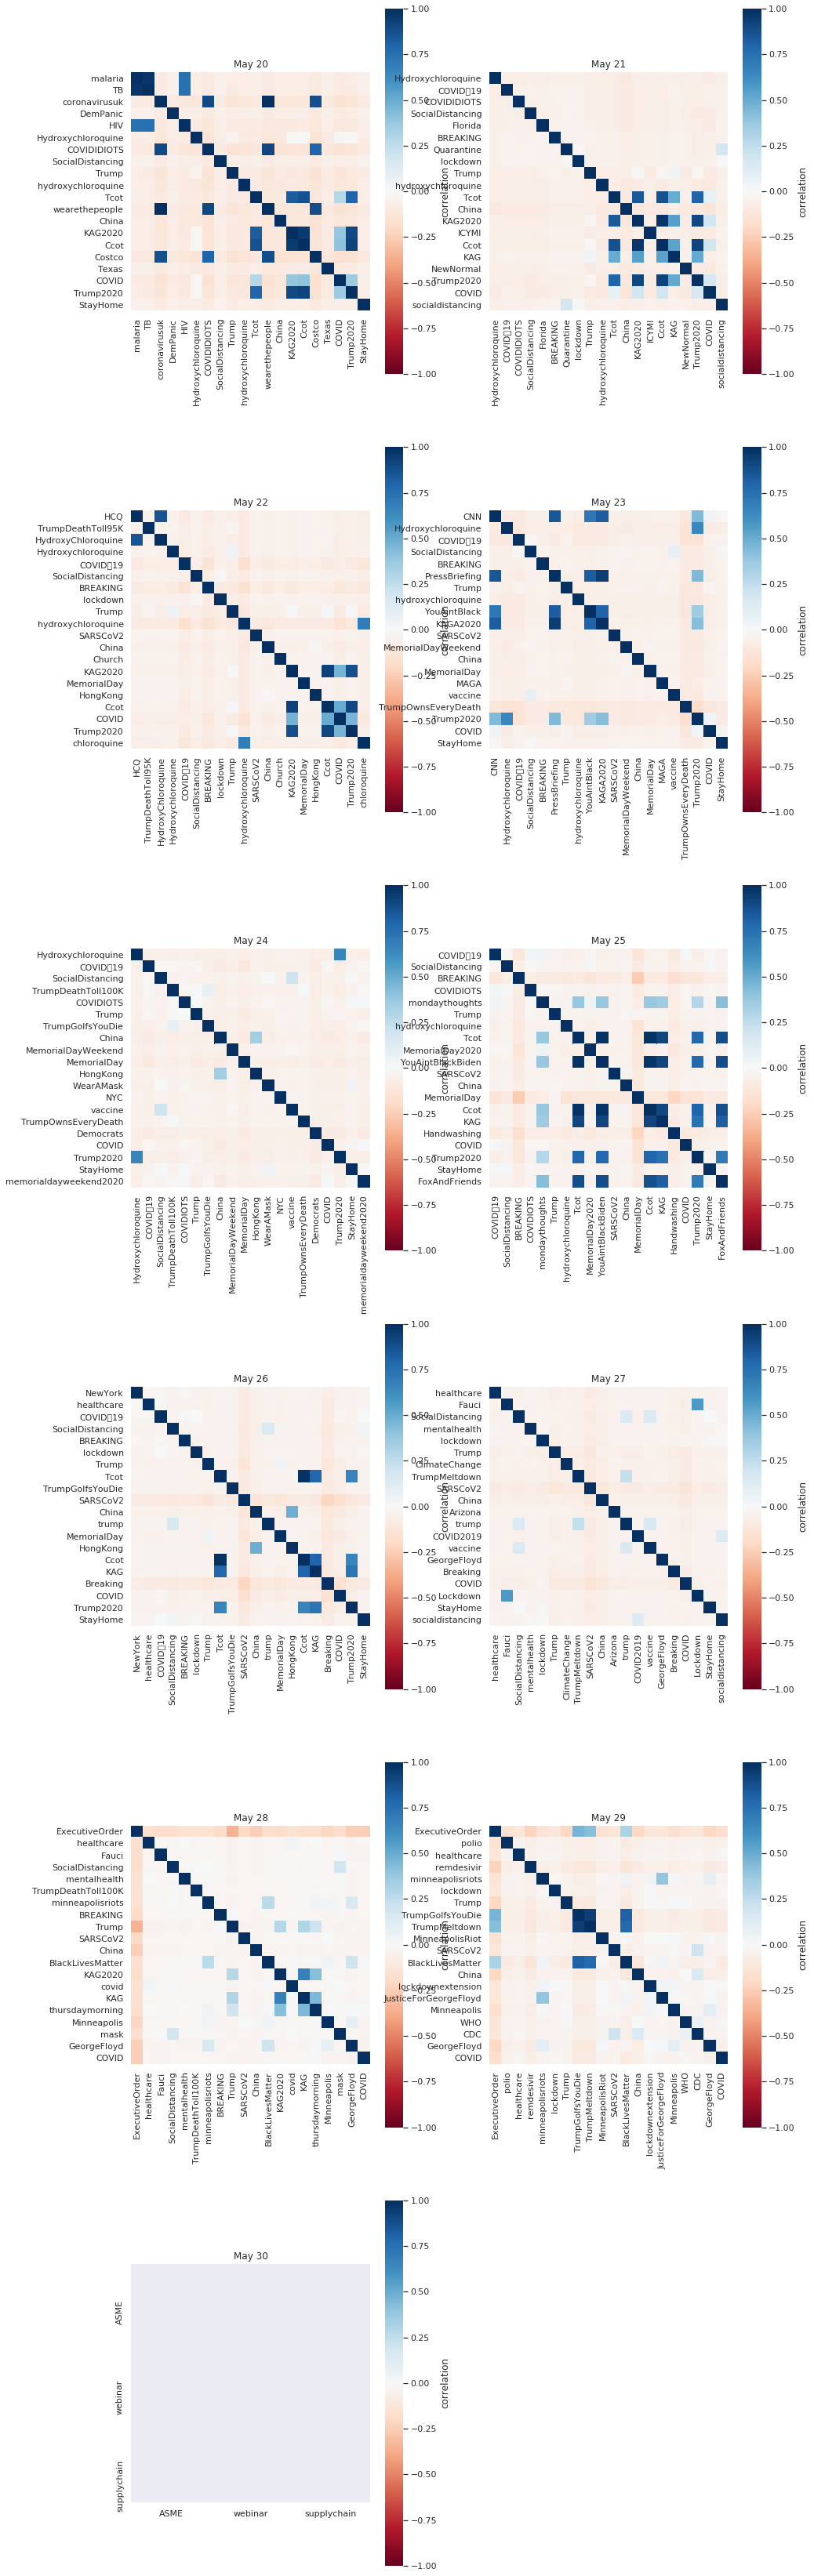

In [124]:
country = 'USA'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# Term Frequency
sns.set(style="darkgrid")
counts_df = getTermFrequency(df_country, tf_count)
counts_df.columns = ['word', 'frequency']
fig, ax = plt.subplots(figsize = (8, 8))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# Hashtags of polar words
clouds = getPolarClouds(df_country, tf_count)

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(clouds.get('positive'))
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(clouds.get('negative'))
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(clouds.get('neutral'))
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(clouds.get('all'))
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
plt.show()



# Sentiment scores daywise
df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# Temporal sentiments
ot = getMovingAverages(df_country, sample, roll)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,30)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.show()



# Clouds of hashtags
p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
displayWordcloud(p.hashtags, "Hashtags cloud", 30)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

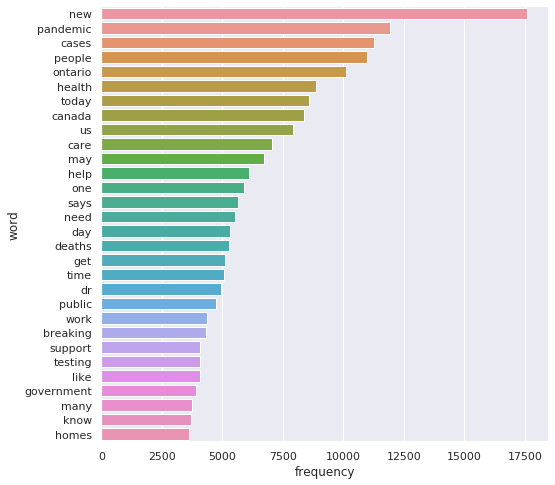

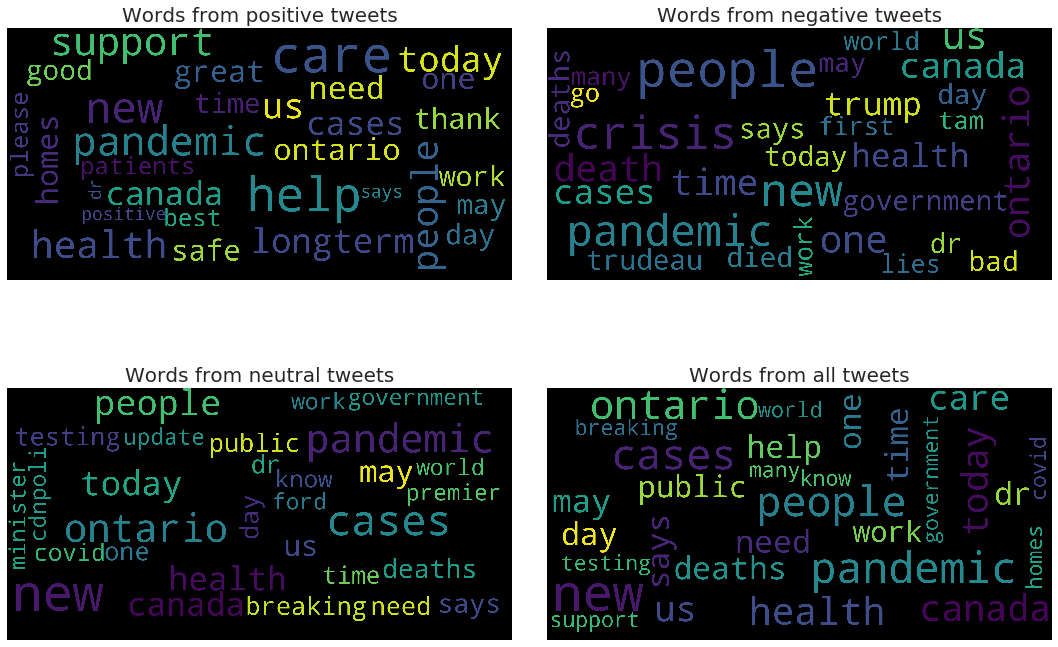

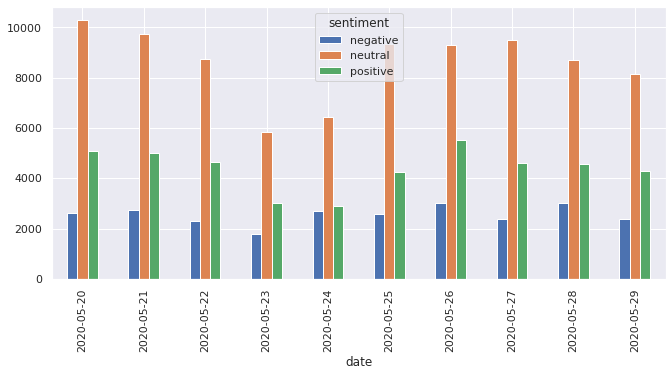

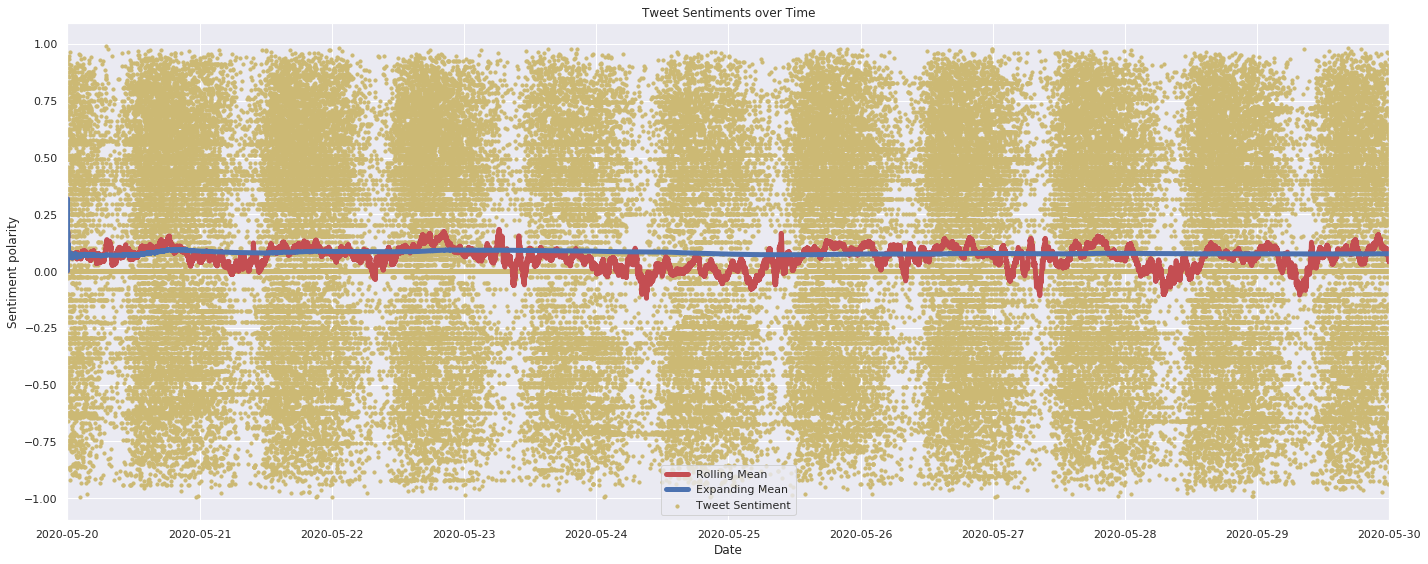

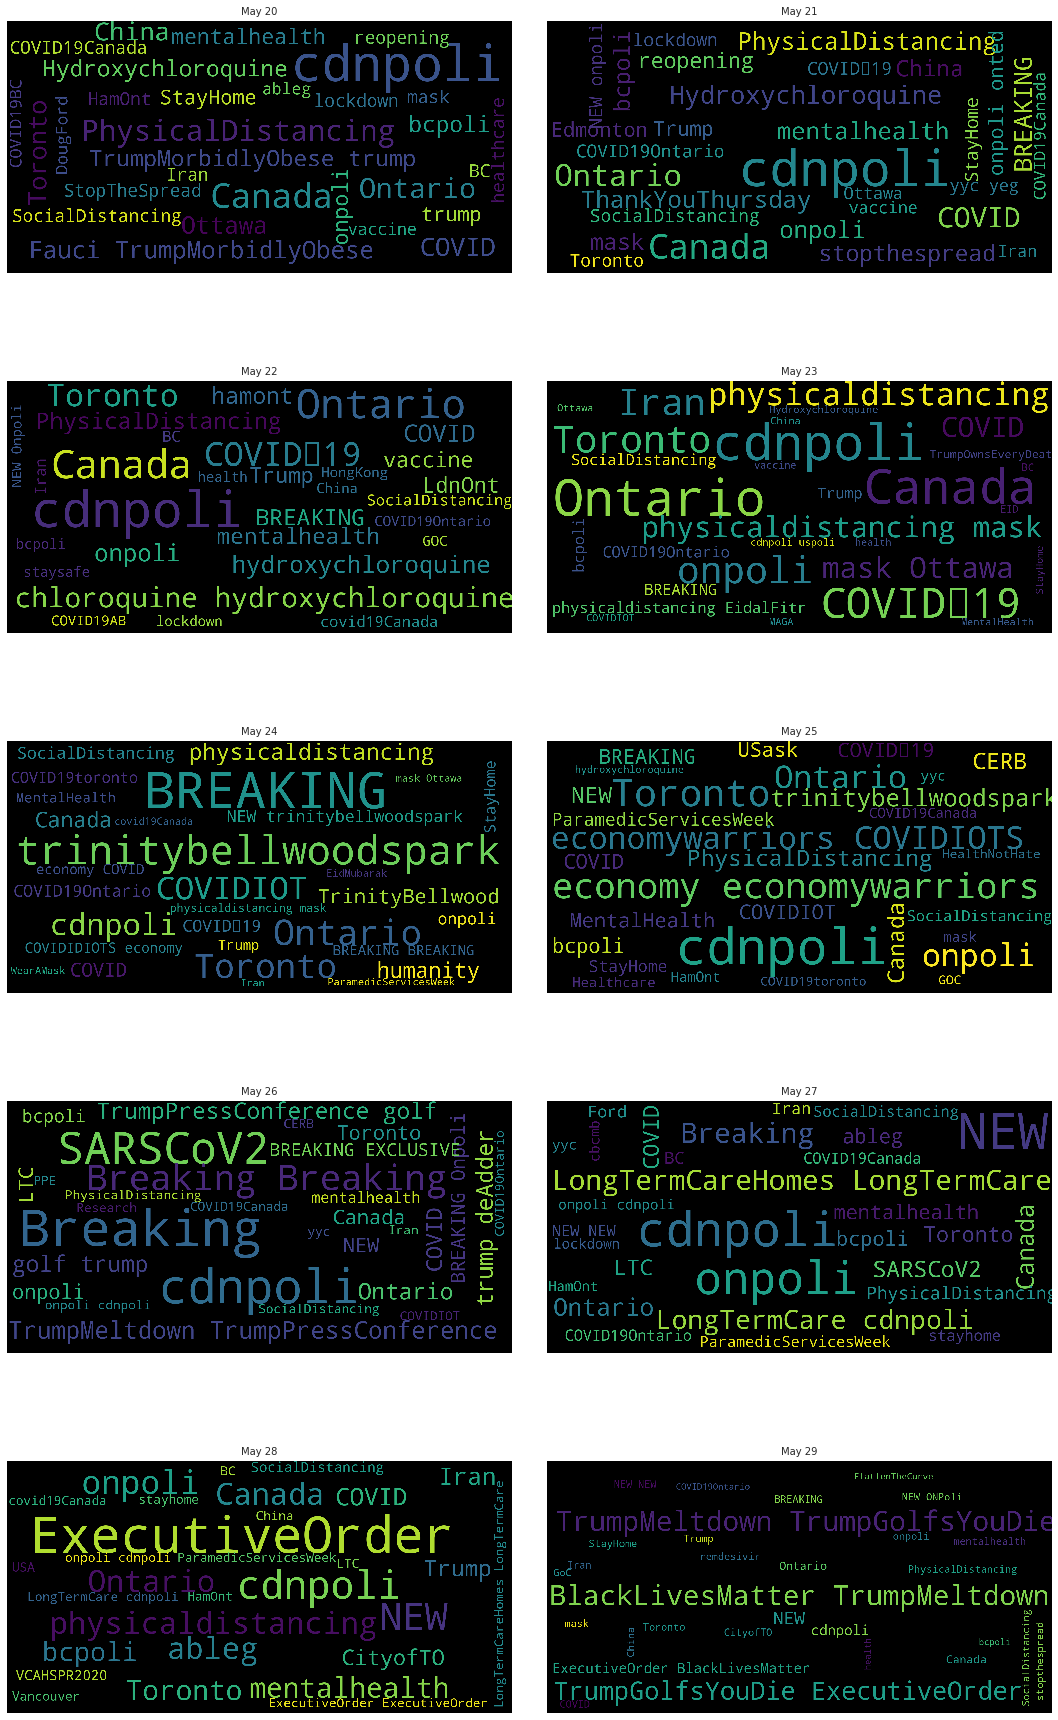

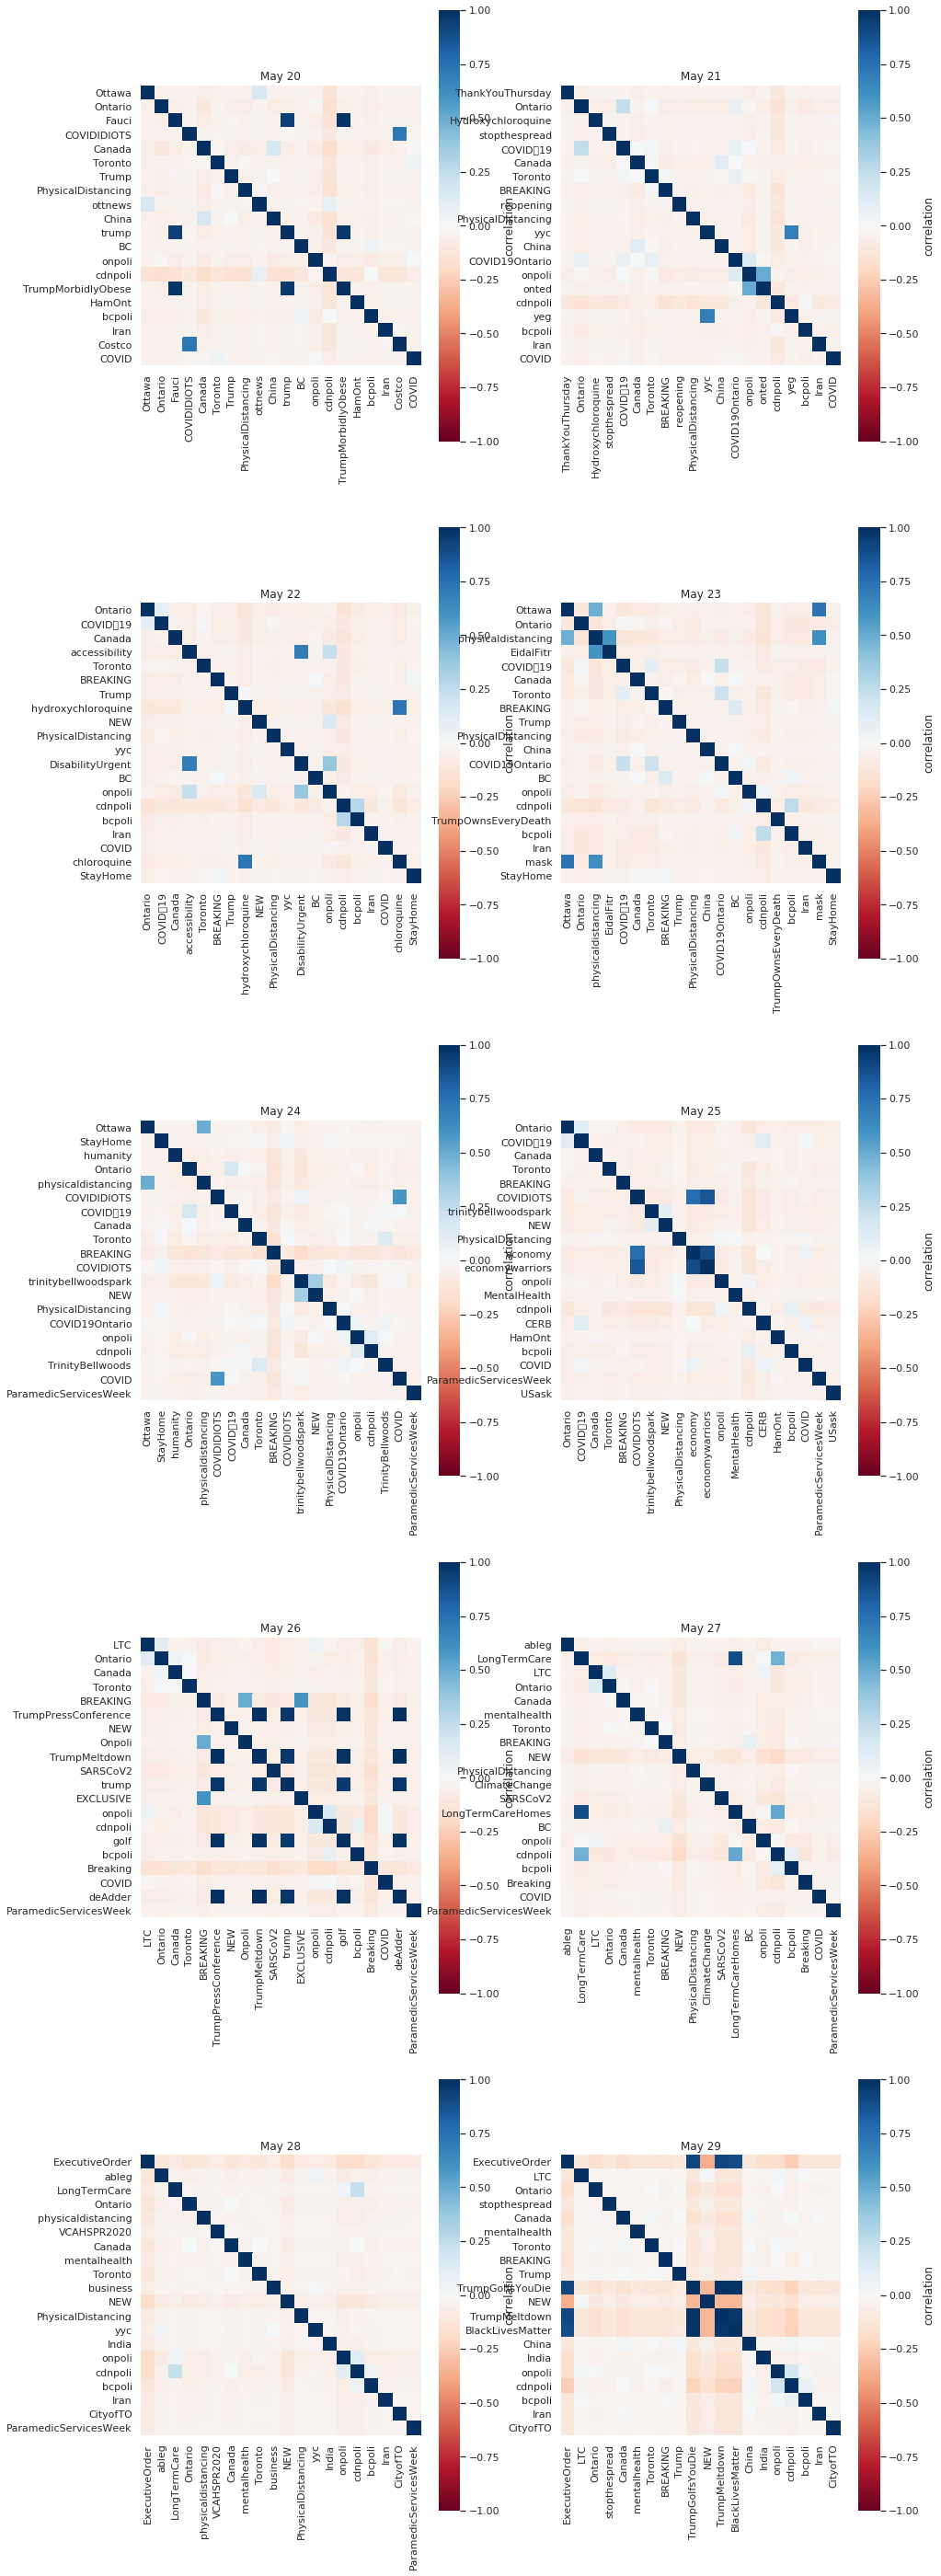

In [125]:
country = 'CAN'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# Term Frequency
sns.set(style="darkgrid")
counts_df = getTermFrequency(df_country, tf_count)
counts_df.columns = ['word', 'frequency']
fig, ax = plt.subplots(figsize = (8, 8))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# Hashtags of polar words
clouds = getPolarClouds(df_country, tf_count)

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(clouds.get('positive'))
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(clouds.get('negative'))
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(clouds.get('neutral'))
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(clouds.get('all'))
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
plt.show()



# Sentiment scores daywise
df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# Temporal sentiments
ot = getMovingAverages(df_country, sample, roll)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,30)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.show()



# Clouds of hashtags
p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
displayWordcloud(p.hashtags, "Hashtags cloud", 30)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

In [177]:
t = df_text[df_text.code == 'GBR']
t.created_at = pd.to_datetime(t.created_at)

# pd.to_datetime(t.iloc[0].created_at).strftime("%m-%d-%Y %H:%M:%S")

In [172]:
t[(t.created_at > '05-22-2020 22:00:00') & (t.created_at < '05-23-2020 04:00:00')]

created_at  \
1193561 2020-05-23 00:00:00+00:00   
1193563 2020-05-22 23:59:59+00:00   
1193591 2020-05-22 23:59:52+00:00   
1193601 2020-05-22 23:59:49+00:00   
1193605 2020-05-22 23:59:48+00:00   
1193618 2020-05-22 23:59:46+00:00   
1193630 2020-05-22 23:59:44+00:00   
1193633 2020-05-22 23:59:44+00:00   
1193640 2020-05-22 23:59:43+00:00   
1193650 2020-05-22 23:59:39+00:00   
1193657 2020-05-22 23:59:37+00:00   
1193668 2020-05-22 23:59:35+00:00   
1193710 2020-05-22 23:59:25+00:00   
1193735 2020-05-22 23:59:15+00:00   
1193746 2020-05-22 23:59:13+00:00   
1193807 2020-05-22 23:58:55+00:00   
1193821 2020-05-22 23:58:52+00:00   
1193825 2020-05-22 23:58:52+00:00   
1193842 2020-05-22 23:58:48+00:00   
1193854 2020-05-22 23:58:44+00:00   
1193857 2020-05-22 23:58:43+00:00   
1193867 2020-05-22 23:58:41+00:00   
1193870 2020-05-22 23:58:39+00:00   
1193893 2020-05-22 23:58:32+00:00   
1193995 2020-05-22 23:58:01+00:00   
1194021 2020-05-22 23:57:55+00:00   
1194025 2020-05-22 23:57:54+00:00   
1194035 2020-05-22 23:57:52+00:00   
1194037 2020-05-22 23:57:52+00:00   
1194042 2020-05-22 23:57:50+00:00   
...                           ...   
2146431 2020-05-23 00:03:53+00:00   
2146467 2020-05-23 00:03:45+00:00   
2146475 2020-05-23 00:03:42+00:00   
2146577 2020-05-23 00:03:17+00:00   
2146593 2020-05-23 00:03:12+00:00   
2146597 2020-05-23 00:03:11+00:00   
2146651 2020-05-23 00:02:58+00:00   
2146672 2020-05-23 00:02:48+00:00   
2146721 2020-05-23 00:02:35+00:00   
2146751 2020-05-23 00:02:24+00:00   
2146767 2020-05-23 00:02:20+00:00   
2146787 2020-05-23 00:02:14+00:00   
2146833 2020-05-23 00:02:04+00:00   
2146834 2020-05-23 00:02:04+00:00   
2146912 2020-05-23 00:01:44+00:00   
2147008 2020-05-23 00:01:23+00:00   
2147050 2020-05-23 00:01:14+00:00   
2147095 2020-05-23 00:01:04+00:00   
2147163 2020-05-23 00:00:52+00:00   
2147172 2020-05-23 00:00:51+00:00   
2147229 2020-05-23 00:00:40+00:00   
2147271 2020-05-23 00:00:32+00:00   
2147292 2020-05-23 00:00:29+00:00   
2147332 2020-05-23 00:00:20+00:00   
2147346 2020-05-23 00:00:17+00:00   
2147372 2020-05-23 00:00:11+00:00   
2147377 2020-05-23 00:00:11+00:00   
2147385 2020-05-23 00:00:10+00:00   
2147410 2020-05-23 00:00:07+00:00   
2147439 2020-05-23 00:00:02+00:00   

                                                 full_text  \
1193561  RT @WHO: "People with #diabetes are vulnerable...   
1193563  @LeshieLoves Your dad should have been given t...   
1193591  RT @WHO: "As the world passes 5 million record...   
1193601  RT @WHO: "Maintaining people’s trust in the ab...   
1193605  RT @RVAwonk: This should be illegal: Through i...   
1193618  RT @WHO: "When health systems are overwhelmed,...   
1193630  RT @peterjukes: On a personal note, I was symp...   
1193633  RT @WHO: "A key part of this week’s landmark #...   
1193640  RT @MEMEMac00965506: Please watch. If like me,...   
1193650  RT @WHO: "As the world passes 5 million record...   
1193657  RT @WHO: Media briefing on #COVID19 with @DrTe...   
1193668  RT @LajnaBaitunNoor: "The best of you are thos...   
1193710  RT @MidwivesRCM: 📣View the latest updates to o...   
1193735  RT @mmaher70: 250 miles from London to Durham ...   
1193746  RT @Mojahedineng: The Iranian regime’s destruc...   
1193807  RT @RCObsGyn: 📢 Updates to our guidance for an...   
1193821  RT @iran_policy: Latest News in Brief – May 22...   
1193825  "The best of you are those who feed others."\n...   
1193842  RT @TheLancet: NEW Research—No evidence of ben...   
1193854  RT @iran_policy: Iran: Coronavirus Update, Ove...   
1193857  RT @RupertaMargate: @afneil But the illegal im...   
1193867  RT @cliodiaspora: I really can’t get my head a...   
1193870  RT @iran_policy: Iran: Coronavirus death toll ...   
1193893  RT @StuartBudd1: @bbclaurak 1/\nThe "separate ...   
1193995  RT @march_change: #Coronavirus: Acting earlier...   
1194021  RT @BloodDonorsIn: #Delhi\nNeed #Blood Type : ...   
1194025  RT @amnestyusa: Around the world, journalists

In [36]:
a = pd.read_csv(main_dir + 'data_full/' + '06-03-2020_full.csv')
a.head()

created_at           id       id_str  \
0  Thu Jun 04 00:00:02 +0000 2020  1.26833e+18  1.26833e+18   
1  Thu Jun 04 00:00:01 +0000 2020  1.26833e+18  1.26833e+18   
2  Thu Jun 04 00:00:01 +0000 2020  1.26833e+18  1.26833e+18   
3  Thu Jun 04 00:00:01 +0000 2020  1.26833e+18  1.26833e+18   
4  Thu Jun 04 00:00:01 +0000 2020  1.26833e+18  1.26833e+18   

                                           full_text truncated  \
0  an opportunity for some people to positively t...     False   
1  New COVID-19 Data at 2020-06-03 08:00:00 pm ED...     False   
2  The focus on self-reliance in #Modi's #COVID19...     False   
3  Stay updated with the latest stories on Corona...     False   
4  #GartnerHR expert @briankropp urges organizati...     False   

  display_text_range                                           entities  \
0           [0, 141]  {'hashtags': [{'text': 'Covid19', 'indices': [...   
1            [0, 69]  {'hashtags': [{'text': 'Coronavirus', 'indices...   
2           [0, 270]  {'hashtags': [{'text': 'Modi', 'indices': [30,...   
3           [0, 128]  {'hashtags': [{'text': 'coronavirus', 'indices...   
4           [0, 220]  {'hashtags': [{'text': 'GartnerHR', 'indices':...   

                                              source  in_reply_to_status_id  \
0  <a href="https://github.com/jakubvalenta/covid...                    NaN   
1  <a href="https://kojospace.com/" rel="nofollow...                    NaN   
2  <a href="https://buffer.com" rel="nofollow">Bu...                    NaN   
3                                                NaN                    NaN   
4  <a href="https://getbambu.com" rel="nofollow">...                    NaN   

   in_reply_to_status_id_str  ... coordinates  place contributors  \
0                        NaN  ...         NaN    NaN          NaN   
1                        NaN  ...         NaN    NaN          NaN   
2                        NaN  ...         NaN    NaN          NaN   
3                        NaN  ...         NaN    NaN          NaN   
4                        NaN  ...         NaN    NaN          NaN   

  is_quote_status retweet_count favorite_count favorited  retweeted  \
0           False             0              0     False      False   
1           False             0              0     False      False   
2           False             0              0     False      False   
3            True             0              0     False      False   
4           False             0              0     False      False   

  possibly_sensitive lang  
0              False   en  
1              False   en  
2              False   en  
3              False   en  
4              False   en  

[5 rows x 25 columns]

In [40]:
int(a.iloc[24].id
)

1268331632123162624

In [175]:
txt = "aihe ain in Spain hai"
x = re.findall(r'\bs\w+', txt)
print(x)

['aihe']


In [205]:
b = df_text['full_text'].apply(lambda x: re.findall(r'\S+zee\S+', x.lower()))
stemmer = SnowballStemmer('english')
c = Counter([word for tweet in b for word in tweet]).most_common()
d = pd.DataFrame.from_dict(c)
# d['stemmed'] = d[0].apply(lambda x: stemmer.stem(x))
# d[d['stemmed'] == 'str']
d

0     1
0                   @zeenews  1126
1           @zeenewsenglish:   649
2             @zeeman_group:   551
3                   #zeenews   520
4                 @azeema_1:   288
..                       ...   ...
668                  doozee.     1
669  https://t.co/h4wxuzee7m     1
670         @the_zee_speaks:     1
671  https://t.co/e1ehmzeexw     1
672  https://t.co/zeee82guid     1

[673 rows x 2 columns]

In [204]:
c

[]

In [198]:
stemmer.stem('stry')

'stri'

In [5]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
retweet_dir = main_dir + 'data_retweets/'
locations_dir = retweet_dir + 'locations/'